# Transformer Hyperparameter Testing with Synthetic Data

This notebook creates synthetic cosine data with different frequencies to test the TransformerClassifier model. We'll generate controlled data that should be easily classifiable, and then evaluate how different hyperparameters affect the model's performance.

The goal is to:
1. Generate synthetic cosine data with distinct classes
2. Train transformer models with different hyperparameter settings
3. Analyze which parameters impact test accuracy the most
4. Compare these findings with our grid search results on real data

## 1. Setup and Synthetic Data Generation

First, let's import necessary libraries and create synthetic cosine data with different frequencies representing different classes.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import sys
import time
import itertools
from tqdm import tqdm

# Add the project root path to system path to import custom modules
import sys
sys.path.append('/home/ianyang/stochastic_simulations')

# Import the transformer model
try:
    from src.models.transformer import TransformerClassifier
except ImportError:
    from models.transformer import TransformerClassifier

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Set up plotting
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)
plt.rcParams['figure.figsize'] = [12, 8]

### 1.1 Generate Synthetic Cosine Data

We'll create data with different frequencies and add some noise to make the classification task more realistic.

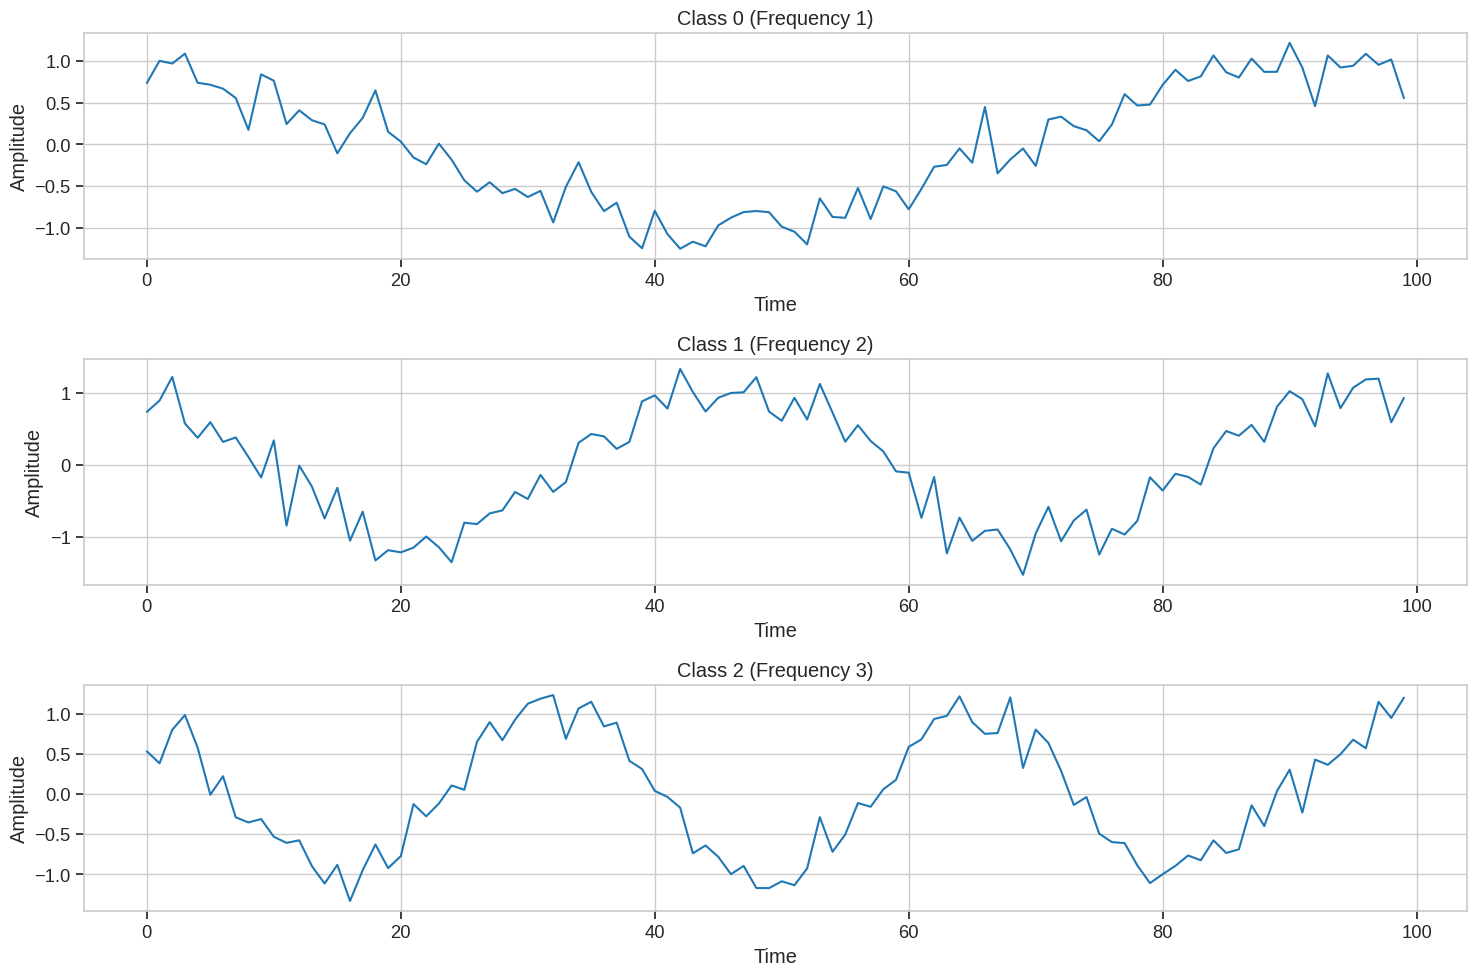

Training set: (700, 100), (700,)
Validation set: (150, 100), (150,)
Test set: (150, 100), (150,)


In [2]:
def generate_cosine_data(n_samples=1000, seq_length=100, n_classes=3, noise_level=0.2):
    """
    Generate synthetic cosine data with different frequencies for classification.
    
    Args:
        n_samples: Number of samples to generate
        seq_length: Length of each sequence
        n_classes: Number of classes (different frequencies)
        noise_level: Amount of noise to add
        
    Returns:
        X: Array of shape (n_samples, seq_length) containing the cosine waves
        y: Array of shape (n_samples,) containing the class labels
    """
    X = np.zeros((n_samples, seq_length))
    y = np.zeros(n_samples, dtype=int)
    
    # Time points
    t = np.linspace(0, 2*np.pi, seq_length)
    
    # Generate data for each class with different frequencies
    samples_per_class = n_samples // n_classes
    
    for i in range(n_classes):
        # Frequency for this class
        freq = i + 1
        
        # Generate cosine waves with the specific frequency
        start_idx = i * samples_per_class
        end_idx = (i + 1) * samples_per_class if i < n_classes - 1 else n_samples
        
        for j in range(start_idx, end_idx):
            # Add some phase shift variation within class
            phase_shift = np.random.uniform(0, np.pi/4)
            
            # Generate the basic cosine wave with specific frequency
            signal = np.cos(freq * t + phase_shift)
            
            # Add random noise
            noise = np.random.normal(0, noise_level, seq_length)
            
            # Combine signal and noise
            X[j] = signal + noise
            
            # Assign class label
            y[j] = i
    
    return X, y

# Generate the synthetic data
n_samples = 1000
seq_length = 100
n_classes = 3
noise_level = 0.2

X, y = generate_cosine_data(n_samples, seq_length, n_classes, noise_level)

# Plot examples from each class
plt.figure(figsize=(15, 10))
for i in range(n_classes):
    plt.subplot(n_classes, 1, i+1)
    
    # Get the first sample of this class
    idx = np.where(y == i)[0][0]
    
    plt.plot(X[idx])
    plt.title(f'Class {i} (Frequency {i+1})')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    
plt.tight_layout()
plt.show()

# Split the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

# Reshape for transformer input [batch, seq_len, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Helper function to convert numpy arrays to PyTorch tensors
def to_tensor(data, labels):
    """Helper to convert arrays to a TensorDataset."""
    return TensorDataset(
        torch.tensor(data, dtype=torch.float32),
        torch.tensor(labels, dtype=torch.long),
    )

## 2. Hyperparameter Testing with TransformerClassifier

Now let's set up our hyperparameter testing framework. We'll test various parameter combinations and analyze their impact on model performance.

In [7]:
# Define hyperparameter ranges to test
hyperparams = {
    'd_model': [32, 64, 128],
    'nhead': [2, 4, 8],
    'num_layers': [1, 2, 3],
    'dropout_rate': [0.1, 0.3],
    'learning_rate': [0.001, 0.01],
    'batch_size': [32, 64],
    'optimizer': ['Adam', 'AdamW'],
    'pooling_strategy': ['last', 'mean'],
    'use_conv1d': [True, False],
    'gradient_clip': [1.0, 5.0]
}

# Create a smaller grid for initial testing
test_grid = {
    'd_model': [64],
    'nhead': [4],
    'num_layers': [2],
    'dropout_rate': [0.1],
    'learning_rate': [0.001],
    'batch_size': [32],
    'optimizer': ['Adam'],
    'pooling_strategy': ['mean'],
    'use_conv1d': [True],
    'gradient_clip': [1.0]
}

# Function to run a single experiment with specified hyperparameters
def run_experiment(X_train, y_train, X_val, y_val, X_test, y_test, hyperparams, epochs=30, patience=5):
    """
    Run a transformer model experiment with the specified hyperparameters.
    
    Args:
        X_train, y_train: Training data
        X_val, y_val: Validation data
        X_test, y_test: Test data
        hyperparams: Dictionary of hyperparameters
        epochs: Maximum number of training epochs
        patience: Early stopping patience
        
    Returns:
        dict: Results including accuracy metrics and training time
    """
    # Create data loaders
    train_loader = DataLoader(
        to_tensor(X_train, y_train), 
        batch_size=hyperparams['batch_size'], 
        shuffle=True
    )
    val_loader = DataLoader(
        to_tensor(X_val, y_val), 
        batch_size=hyperparams['batch_size']
    )
    test_loader = DataLoader(
        to_tensor(X_test, y_test), 
        batch_size=hyperparams['batch_size']
    )
    
    # Measure training time
    start_time = time.time()
    
    # Create and train the model
    model = TransformerClassifier(
        input_size=1,
        d_model=hyperparams['d_model'],
        nhead=hyperparams['nhead'],
        num_layers=hyperparams['num_layers'],
        output_size=n_classes,
        dropout_rate=hyperparams['dropout_rate'],
        learning_rate=hyperparams['learning_rate'],
        optimizer=hyperparams['optimizer'],
        use_conv1d=hyperparams['use_conv1d'],
        pooling_strategy=hyperparams['pooling_strategy'],
        gradient_clip=hyperparams['gradient_clip']
    )
    
    # Train the model
    history = model.train_model(train_loader, val_loader, epochs=epochs, patience=patience)
    
    # Evaluate on test set
    test_acc = model.evaluate(test_loader)
    
    # Calculate training time
    train_time = time.time() - start_time
    
    # Return results
    result = {
        **hyperparams,
        'train_acc': history['train_acc'][-1] if 'train_acc' in history else None,
        'val_acc': history['val_acc'][-1] if 'val_acc' in history else None,
        'test_acc': test_acc,
        'time': train_time
    }
    
    return result

# Test the model with default parameters to verify it works
print("Running test experiment with default parameters...")
# Extract single values from test_grid
test_params = {k: v[0] for k, v in test_grid.items()}
test_result = run_experiment(X_train, y_train, X_val, y_val, X_test, y_test, test_params)
print(f"Test result: {test_result}")

Running test experiment with default parameters...
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/30], Loss: 1.4890, Train Acc: 0.3514
Validation Acc: 0.3333
Epoch [2/30], Loss: 1.3071, Train Acc: 0.3900
Validation Acc: 0.6733
Epoch [3/30], Loss: 1.1451, Train Acc: 0.4371
Validation Acc: 0.7333
Epoch [4/30], Loss: 1.0444, Train Acc: 0.5186
Validation Acc: 0.8333
Epoch [5/30], Loss: 0.9115, Train Acc: 0.5886
Validation Acc: 0.9000
Epoch [6/30], Loss: 0.8065, Train Acc: 0.6829
Validation Acc: 0.9267
Epoch [7/30], Loss: 0.7675, Train Acc: 0.7157
Validation Acc: 1.0000
Epoch [8/30], Loss: 0.6856, Train Acc: 0.7657
Validation Acc: 1.0000
No improvement (1/5).
Epoch [9/30], Loss: 0.6165, Train Acc: 0.8257
Validation Acc: 1.0000
No improvement (2/5).
Epoch [10/30], Loss: 0.5706, Train Acc: 0.8543
Validation Acc: 1.0000
No improvement (3/5).
Epoch [11/30], Loss: 0.5547, Train Acc: 0.8686
Validation Acc: 1.0000
No improvement (4/5).
Epoch 

## 3. Test Individual Hyperparameters

Now let's systematically test the impact of individual hyperparameters by varying one at a time while keeping others constant.

In [8]:
# Use the best/default parameter set as baseline
baseline_params = {
    'd_model': 64,
    'nhead': 4,
    'num_layers': 2,
    'dropout_rate': 0.1,
    'learning_rate': 0.001,
    'batch_size': 32,
    'optimizer': 'Adam',
    'pooling_strategy': 'mean',
    'use_conv1d': True,
    'gradient_clip': 1.0
}

# Improved function to test impact of a single hyperparameter
def test_parameter_impact(param_name, param_values, baseline, X_train, y_train, X_val, y_val, X_test, y_test):
    """
    Test the impact of a single hyperparameter on model performance.
    
    Args:
        param_name: Name of the hyperparameter to test
        param_values: List of values to test for this hyperparameter
        baseline: Dictionary of baseline hyperparameter values
        X_train, y_train, X_val, y_val, X_test, y_test: Data
        
    Returns:
        List of results for each parameter value
    """
    results = []
    failed_experiments = []
    
    # Create a results dataframe to save progress
    interim_results_df = pd.DataFrame()
    
    for value in tqdm(param_values, desc=f"Testing {param_name}"):
        try:
            # Create a copy of baseline parameters and update the test parameter
            params = baseline.copy()
            params[param_name] = value
            
            # Pre-validate and fix incompatible hyperparameters
            if param_name == 'nhead' and value > params['d_model']:
                print(f"Warning: nhead={value} > d_model={params['d_model']}. Adjusting d_model to {value}.")
                params['d_model'] = value
            elif param_name == 'd_model' and params['nhead'] > value:
                print(f"Warning: d_model={value} < nhead={params['nhead']}. Adjusting nhead to {value}.")
                params['nhead'] = value
            
            # Run experiment with these parameters
            result = run_experiment(X_train, y_train, X_val, y_val, X_test, y_test, params)
            
            # Add the result to our list
            results.append(result)
            
            # Check if experiment succeeded
            if 'status' in result and result['status'] == 'failed':
                failed_experiments.append((value, result.get('error', 'Unknown error')))
                print(f"  Experiment failed with {param_name}={value}: {result.get('error', 'Unknown error')}")
            
            # Save interim results to dataframe
            try:
                interim_results_df = pd.concat([interim_results_df, pd.DataFrame([result])], ignore_index=True)
                interim_results_df.to_csv(f'interim_results_{param_name}.csv', index=False)
            except Exception as e:
                print(f"Failed to save interim results: {e}")
                
        except Exception as e:
            print(f"Error testing {param_name}={value}: {str(e)}")
            failed_experiments.append((value, str(e)))
            
            # Still record the failure in results
            error_result = {
                **baseline.copy(),
                param_name: value,
                'train_acc': None,
                'val_acc': None,
                'test_acc': 0.0,
                'time': 0.0,
                'status': 'failed',
                'error': str(e)
            }
            results.append(error_result)
    
    # Report any failed experiments
    if failed_experiments:
        print(f"\nWarning: {len(failed_experiments)} experiments failed for {param_name}:")
        for value, error in failed_experiments:
            print(f"  {param_name}={value}: {error}")
    
    return results

# Parameters to test
params_to_test = {
    'd_model': [32, 64, 128, 256],
    'nhead': [2, 4, 8],
    'num_layers': [1, 2, 3, 4],
    'dropout_rate': [0.0, 0.1, 0.2, 0.3, 0.4],
    'learning_rate': [0.0001, 0.001, 0.01],
    'batch_size': [16, 32, 64, 128],
    'optimizer': ['Adam', 'AdamW', 'SGD'],
    'pooling_strategy': ['last', 'mean', 'learnable'],
    'use_conv1d': [True, False],
    'gradient_clip': [0.0, 1.0, 5.0, 10.0]
}

# Select a subset of parameters to test
test_params = ['d_model', 'nhead', 'num_layers', 'dropout_rate', 'pooling_strategy', 'use_conv1d']

# Run experiments for each parameter
all_results = {}
all_valid_results = {}  # Store only successful results

for param in test_params:
    print(f"\nTesting impact of {param}...")
    param_results = test_parameter_impact(
        param, 
        params_to_test[param], 
        baseline_params,
        X_train, y_train, X_val, y_val, X_test, y_test
    )
    all_results[param] = param_results
    
    # Filter out failed experiments for analysis
    valid_results = [r for r in param_results if r.get('status', '') == 'success']
    all_valid_results[param] = valid_results
    
    # Print current results
    print(f"Results for {param}:")
    for result in param_results:
        status = "✓" if result.get('status', '') == 'success' else "✗"
        print(f"  {status} {param}={result[param]}, Test Acc: {result['test_acc']:.4f}, Train Time: {result['time']:.2f}s")
    
    # Save results after each parameter
    try:
        pd.DataFrame(param_results).to_csv(f'results_{param}.csv', index=False)
        print(f"Results saved to results_{param}.csv")
    except Exception as e:
        print(f"Failed to save results: {e}")


Testing impact of d_model...


Testing d_model:   0%|          | 0/4 [00:00<?, ?it/s]

🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/30], Loss: 2.1126, Train Acc: 0.3357
Validation Acc: 0.3333


/home/ianyang/stochastic_simulations/micromamba/envs/stochastic_sim/lib/python3.11/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch [2/30], Loss: 1.9212, Train Acc: 0.3386
Validation Acc: 0.3333
No improvement (1/5).
Epoch [3/30], Loss: 1.5979, Train Acc: 0.3243
Validation Acc: 0.3333
No improvement (2/5).
Epoch [4/30], Loss: 1.3146, Train Acc: 0.3257
Validation Acc: 0.3333
No improvement (3/5).
Epoch [5/30], Loss: 1.1509, Train Acc: 0.4000
Validation Acc: 0.7267
Epoch [6/30], Loss: 0.9807, Train Acc: 0.5586
Validation Acc: 0.8333
Epoch [7/30], Loss: 0.8822, Train Acc: 0.6229
Validation Acc: 0.9200
Epoch [8/30], Loss: 0.8146, Train Acc: 0.6614
Validation Acc: 0.9467
Epoch [9/30], Loss: 0.7366, Train Acc: 0.7071
Validation Acc: 0.9733
Epoch [10/30], Loss: 0.6720, Train Acc: 0.7914
Validation Acc: 0.9667
No improvement (1/5).
Epoch [11/30], Loss: 0.6218, Train Acc: 0.8443
Validation Acc: 0.9800
Epoch [12/30], Loss: 0.5979, Train Acc: 0.8529
Validation Acc: 0.9800
No improvement (1/5).
Epoch [13/30], Loss: 0.5800, Train Acc: 0.8614
Validation Acc: 0.9800
No improvement (2/5).
Epoch [14/30], Loss: 0.5328, Train A

Testing d_model:  25%|██▌       | 1/4 [00:02<00:07,  2.65s/it]

Epoch [20/30], Loss: 0.4580, Train Acc: 0.9457
Validation Acc: 1.0000
No improvement (5/5).
Stopping early! No improvement for 5 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/30], Loss: 3.9069, Train Acc: 0.3371
Validation Acc: 0.3333
Epoch [2/30], Loss: 3.0725, Train Acc: 0.3557
Validation Acc: 0.3333
No improvement (1/5).
Epoch [3/30], Loss: 1.7372, Train Acc: 0.3614
Validation Acc: 0.3333
No improvement (2/5).
Epoch [4/30], Loss: 1.2483, Train Acc: 0.4143
Validation Acc: 0.6067
Epoch [5/30], Loss: 1.0539, Train Acc: 0.4900
Validation Acc: 0.6533
Epoch [6/30], Loss: 0.9818, Train Acc: 0.5571
Validation Acc: 0.8533
Epoch [7/30], Loss: 0.8661, Train Acc: 0.6500
Validation Acc: 0.9267
Epoch [8/30], Loss: 0.7670, Train Acc: 0.7200
Validation Acc: 0.9800
Epoch [9/30], Loss: 0.7106, Train Acc: 0.7457
Validation Acc: 0.9467
No improvement (1/5).
Epoch [10/30], Loss: 0.6248, Train Acc: 0.8171
Validation Acc: 

Testing d_model:  50%|█████     | 2/4 [00:04<00:04,  2.36s/it]

Epoch [16/30], Loss: 0.4320, Train Acc: 0.9400
Validation Acc: 1.0000
No improvement (5/5).
Stopping early! No improvement for 5 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/30], Loss: 2.1095, Train Acc: 0.3043
Validation Acc: 0.3333
Epoch [2/30], Loss: 1.4770, Train Acc: 0.3471
Validation Acc: 0.6067
Epoch [3/30], Loss: 1.0779, Train Acc: 0.4843
Validation Acc: 0.6800
Epoch [4/30], Loss: 0.8626, Train Acc: 0.6329
Validation Acc: 0.8333
Epoch [5/30], Loss: 0.6694, Train Acc: 0.7857
Validation Acc: 0.9933
Epoch [6/30], Loss: 0.5358, Train Acc: 0.8900
Validation Acc: 0.9933
No improvement (1/5).
Epoch [7/30], Loss: 0.4648, Train Acc: 0.9486
Validation Acc: 1.0000
Epoch [8/30], Loss: 0.4156, Train Acc: 0.9600
Validation Acc: 1.0000
No improvement (1/5).
Epoch [9/30], Loss: 0.3901, Train Acc: 0.9800
Validation Acc: 1.0000
No improvement (2/5).
Epoch [10/30], Loss: 0.3732, Train Acc: 0.9843
Validation Acc: 

Testing d_model:  75%|███████▌  | 3/4 [00:06<00:02,  2.01s/it]

Epoch [12/30], Loss: 0.3536, Train Acc: 0.9900
Validation Acc: 1.0000
No improvement (5/5).
Stopping early! No improvement for 5 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/30], Loss: 1.7831, Train Acc: 0.3157
Validation Acc: 0.3333
Epoch [2/30], Loss: 1.2546, Train Acc: 0.4600
Validation Acc: 0.4533
Epoch [3/30], Loss: 0.8711, Train Acc: 0.6500
Validation Acc: 0.8467
Epoch [4/30], Loss: 0.6163, Train Acc: 0.8314
Validation Acc: 0.9800
Epoch [5/30], Loss: 0.4795, Train Acc: 0.9171
Validation Acc: 1.0000
Epoch [6/30], Loss: 0.4187, Train Acc: 0.9457
Validation Acc: 0.9933
No improvement (1/5).
Epoch [7/30], Loss: 0.3603, Train Acc: 0.9914
Validation Acc: 1.0000
No improvement (2/5).
Epoch [8/30], Loss: 0.3416, Train Acc: 0.9943
Validation Acc: 1.0000
No improvement (3/5).
Epoch [9/30], Loss: 0.3369, Train Acc: 0.9971
Validation Acc: 1.0000
No improvement (4/5).
Epoch [10/30], Loss: 0.3326, Train Acc: 0

Testing d_model: 100%|██████████| 4/4 [00:08<00:00,  2.11s/it]


Results for d_model:
  ✗ d_model=32, Test Acc: 1.0000, Train Time: 2.65s
  ✗ d_model=64, Test Acc: 1.0000, Train Time: 2.15s
  ✗ d_model=128, Test Acc: 1.0000, Train Time: 1.60s
  ✗ d_model=256, Test Acc: 1.0000, Train Time: 2.03s
Results saved to results_d_model.csv

Testing impact of nhead...


Testing nhead:   0%|          | 0/3 [00:00<?, ?it/s]/home/ianyang/stochastic_simulations/micromamba/envs/stochastic_sim/lib/python3.11/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/30], Loss: 1.6329, Train Acc: 0.3529
Validation Acc: 0.3333
Epoch [2/30], Loss: 1.4264, Train Acc: 0.3886
Validation Acc: 0.7467
Epoch [3/30], Loss: 1.1542, Train Acc: 0.4529
Validation Acc: 0.9267
Epoch [4/30], Loss: 0.9563, Train Acc: 0.5500
Validation Acc: 0.9067
No improvement (1/5).
Epoch [5/30], Loss: 0.8477, Train Acc: 0.6171
Validation Acc: 0.8800
No improvement (2/5).
Epoch [6/30], Loss: 0.7508, Train Acc: 0.7286
Validation Acc: 0.8733
No improvement (3/5).
Epoch [7/30], Loss: 0.6531, Train Acc: 0.7943
Validation Acc: 0.8933
No improvement (4/5).


Testing nhead:  33%|███▎      | 1/3 [00:01<00:02,  1.10s/it]

Epoch [8/30], Loss: 0.5773, Train Acc: 0.8529
Validation Acc: 0.9267
No improvement (5/5).
Stopping early! No improvement for 5 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/30], Loss: 2.6598, Train Acc: 0.3343
Validation Acc: 0.3333
Epoch [2/30], Loss: 2.1098, Train Acc: 0.3043
Validation Acc: 0.3000
No improvement (1/5).
Epoch [3/30], Loss: 1.3391, Train Acc: 0.4186
Validation Acc: 0.5467
Epoch [4/30], Loss: 1.0498, Train Acc: 0.5314
Validation Acc: 0.9467
Epoch [5/30], Loss: 0.8899, Train Acc: 0.6214
Validation Acc: 0.8867
No improvement (1/5).
Epoch [6/30], Loss: 0.7430, Train Acc: 0.7400
Validation Acc: 0.9933
Epoch [7/30], Loss: 0.6249, Train Acc: 0.8200
Validation Acc: 1.0000
Epoch [8/30], Loss: 0.5465, Train Acc: 0.8814
Validation Acc: 1.0000
No improvement (1/5).
Epoch [9/30], Loss: 0.5078, Train Acc: 0.9086
Validation Acc: 1.0000
No improvement (2/5).
Epoch [10/30], Loss: 0.4598, Train Acc: 0.

Testing nhead:  67%|██████▋   | 2/3 [00:02<00:01,  1.39s/it]

Epoch [12/30], Loss: 0.4307, Train Acc: 0.9543
Validation Acc: 1.0000
No improvement (5/5).
Stopping early! No improvement for 5 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/30], Loss: 2.7088, Train Acc: 0.3400
Validation Acc: 0.3333
Epoch [2/30], Loss: 1.9892, Train Acc: 0.3371
Validation Acc: 0.3800
Epoch [3/30], Loss: 1.1914, Train Acc: 0.4200
Validation Acc: 0.4133
Epoch [4/30], Loss: 0.9838, Train Acc: 0.5414
Validation Acc: 0.8000
Epoch [5/30], Loss: 0.8633, Train Acc: 0.6457
Validation Acc: 0.9333
Epoch [6/30], Loss: 0.7709, Train Acc: 0.6943
Validation Acc: 0.9533
Epoch [7/30], Loss: 0.7054, Train Acc: 0.7557
Validation Acc: 0.9867
Epoch [8/30], Loss: 0.6168, Train Acc: 0.8371
Validation Acc: 0.9733
No improvement (1/5).
Epoch [9/30], Loss: 0.5614, Train Acc: 0.8686
Validation Acc: 0.9933
Epoch [10/30], Loss: 0.5360, Train Acc: 0.8914
Validation Acc: 0.9933
No improvement (1/5).
Epoch [11/30], 

Testing nhead: 100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


Epoch [16/30], Loss: 0.4145, Train Acc: 0.9729
Validation Acc: 1.0000
No improvement (5/5).
Stopping early! No improvement for 5 epochs.
Training complete!
Results for nhead:
  ✗ nhead=2, Test Acc: 0.9333, Train Time: 1.09s
  ✗ nhead=4, Test Acc: 1.0000, Train Time: 1.59s
  ✗ nhead=8, Test Acc: 0.9933, Train Time: 2.12s
Results saved to results_nhead.csv

Testing impact of num_layers...


Testing num_layers:   0%|          | 0/4 [00:00<?, ?it/s]

🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/30], Loss: 1.8479, Train Acc: 0.3400
Validation Acc: 0.2400


/home/ianyang/stochastic_simulations/micromamba/envs/stochastic_sim/lib/python3.11/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch [2/30], Loss: 1.6439, Train Acc: 0.3400
Validation Acc: 0.3467
Epoch [3/30], Loss: 1.3639, Train Acc: 0.3386
Validation Acc: 0.5933
Epoch [4/30], Loss: 1.1734, Train Acc: 0.4129
Validation Acc: 0.6400
Epoch [5/30], Loss: 1.1163, Train Acc: 0.4600
Validation Acc: 0.6600
Epoch [6/30], Loss: 0.9918, Train Acc: 0.5243
Validation Acc: 0.7333
Epoch [7/30], Loss: 0.9040, Train Acc: 0.6257
Validation Acc: 0.8600
Epoch [8/30], Loss: 0.8311, Train Acc: 0.6629
Validation Acc: 0.8933
Epoch [9/30], Loss: 0.7877, Train Acc: 0.6843
Validation Acc: 0.9133
Epoch [10/30], Loss: 0.7424, Train Acc: 0.7314
Validation Acc: 0.9267
Epoch [11/30], Loss: 0.6913, Train Acc: 0.7700
Validation Acc: 0.9400
Epoch [12/30], Loss: 0.6565, Train Acc: 0.8043
Validation Acc: 0.9467
Epoch [13/30], Loss: 0.6284, Train Acc: 0.8129
Validation Acc: 0.9733
Epoch [14/30], Loss: 0.5866, Train Acc: 0.8614
Validation Acc: 0.9800
Epoch [15/30], Loss: 0.5470, Train Acc: 0.8871
Validation Acc: 0.9800
No improvement (1/5).
Epoch 

Testing num_layers:  25%|██▌       | 1/4 [00:02<00:06,  2.16s/it]

Epoch [21/30], Loss: 0.4470, Train Acc: 0.9414
Validation Acc: 1.0000
No improvement (4/5).
Epoch [22/30], Loss: 0.4524, Train Acc: 0.9543
Validation Acc: 1.0000
No improvement (5/5).
Stopping early! No improvement for 5 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/30], Loss: 1.5376, Train Acc: 0.3629
Validation Acc: 0.3333
Epoch [2/30], Loss: 1.4508, Train Acc: 0.3671
Validation Acc: 0.3333
No improvement (1/5).
Epoch [3/30], Loss: 1.3187, Train Acc: 0.4171
Validation Acc: 0.6333
Epoch [4/30], Loss: 1.1492, Train Acc: 0.4771
Validation Acc: 0.8067
Epoch [5/30], Loss: 1.0041, Train Acc: 0.5486
Validation Acc: 0.8867
Epoch [6/30], Loss: 0.8992, Train Acc: 0.6129
Validation Acc: 0.9400
Epoch [7/30], Loss: 0.8146, Train Acc: 0.6829
Validation Acc: 0.9600
Epoch [8/30], Loss: 0.7279, Train Acc: 0.7300
Validation Acc: 0.9867
Epoch [9/30], Loss: 0.6560, Train Acc: 0.8129
Validation Acc: 0.9867
No improvement 

Testing num_layers:  50%|█████     | 2/4 [00:04<00:04,  2.06s/it]

Epoch [15/30], Loss: 0.4448, Train Acc: 0.9486
Validation Acc: 1.0000
No improvement (5/5).
Stopping early! No improvement for 5 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/30], Loss: 4.0621, Train Acc: 0.3543
Validation Acc: 0.3467
Epoch [2/30], Loss: 3.1315, Train Acc: 0.3243
Validation Acc: 0.3333
No improvement (1/5).
Epoch [3/30], Loss: 1.6567, Train Acc: 0.3600
Validation Acc: 0.5067
Epoch [4/30], Loss: 0.9957, Train Acc: 0.5457
Validation Acc: 0.7267
Epoch [5/30], Loss: 0.7371, Train Acc: 0.7257
Validation Acc: 0.8067
Epoch [6/30], Loss: 0.6493, Train Acc: 0.7914
Validation Acc: 0.9600
Epoch [7/30], Loss: 0.6029, Train Acc: 0.8400
Validation Acc: 0.9333
No improvement (1/5).
Epoch [8/30], Loss: 0.5681, Train Acc: 0.8657
Validation Acc: 0.9533
No improvement (2/5).
Epoch [9/30], Loss: 0.5118, Train Acc: 0.9143
Validation Acc: 0.9933
Epoch [10/30], Loss: 0.4669, Train Acc: 0.9471
Validation Acc: 

Testing num_layers:  75%|███████▌  | 3/4 [00:07<00:02,  2.52s/it]

Epoch [18/30], Loss: 0.3933, Train Acc: 0.9686
Validation Acc: 1.0000
No improvement (5/5).
Stopping early! No improvement for 5 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/30], Loss: 2.7814, Train Acc: 0.3229
Validation Acc: 0.3333
Epoch [2/30], Loss: 1.9665, Train Acc: 0.3286
Validation Acc: 0.5333
Epoch [3/30], Loss: 1.5516, Train Acc: 0.3657
Validation Acc: 0.9000
Epoch [4/30], Loss: 1.1450, Train Acc: 0.5071
Validation Acc: 0.9933
Epoch [5/30], Loss: 0.8660, Train Acc: 0.6514
Validation Acc: 0.9800
No improvement (1/5).
Epoch [6/30], Loss: 0.7387, Train Acc: 0.7186
Validation Acc: 1.0000
Epoch [7/30], Loss: 0.6596, Train Acc: 0.7800
Validation Acc: 1.0000
No improvement (1/5).
Epoch [8/30], Loss: 0.5735, Train Acc: 0.8486
Validation Acc: 1.0000
No improvement (2/5).
Epoch [9/30], Loss: 0.5795, Train Acc: 0.8471
Validation Acc: 1.0000
No improvement (3/5).
Epoch [10/30], Loss: 0.5174, Train Acc: 0

Testing num_layers: 100%|██████████| 4/4 [00:09<00:00,  2.37s/it]


Validation Acc: 1.0000
No improvement (5/5).
Stopping early! No improvement for 5 epochs.
Training complete!
Results for num_layers:
  ✗ num_layers=1, Test Acc: 0.9800, Train Time: 2.16s
  ✗ num_layers=2, Test Acc: 1.0000, Train Time: 1.99s
  ✗ num_layers=3, Test Acc: 1.0000, Train Time: 3.06s
  ✗ num_layers=4, Test Acc: 1.0000, Train Time: 2.24s
Results saved to results_num_layers.csv

Testing impact of dropout_rate...


Testing dropout_rate:   0%|          | 0/5 [00:00<?, ?it/s]

🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/30], Loss: 1.1042, Train Acc: 0.5800
Validation Acc: 0.3333


/home/ianyang/stochastic_simulations/micromamba/envs/stochastic_sim/lib/python3.11/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch [2/30], Loss: 0.8491, Train Acc: 0.6657
Validation Acc: 0.6333
Epoch [3/30], Loss: 0.6401, Train Acc: 0.8900
Validation Acc: 0.9667
Epoch [4/30], Loss: 0.5055, Train Acc: 0.9729
Validation Acc: 0.9800
Epoch [5/30], Loss: 0.4302, Train Acc: 0.9857
Validation Acc: 0.9933
Epoch [6/30], Loss: 0.4037, Train Acc: 0.9914
Validation Acc: 1.0000
Epoch [7/30], Loss: 0.3781, Train Acc: 0.9929
Validation Acc: 1.0000
No improvement (1/5).
Epoch [8/30], Loss: 0.3532, Train Acc: 0.9971
Validation Acc: 1.0000
No improvement (2/5).
Epoch [9/30], Loss: 0.3427, Train Acc: 0.9986
Validation Acc: 1.0000
No improvement (3/5).


Testing dropout_rate:  20%|██        | 1/5 [00:01<00:05,  1.39s/it]

Epoch [10/30], Loss: 0.3258, Train Acc: 0.9986
Validation Acc: 1.0000
No improvement (4/5).
Epoch [11/30], Loss: 0.3163, Train Acc: 1.0000
Validation Acc: 1.0000
No improvement (5/5).
Stopping early! No improvement for 5 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/30], Loss: 2.1145, Train Acc: 0.3486
Validation Acc: 0.3333
Epoch [2/30], Loss: 1.6472, Train Acc: 0.3129
Validation Acc: 0.3067
No improvement (1/5).
Epoch [3/30], Loss: 1.4549, Train Acc: 0.3257
Validation Acc: 0.4600
Epoch [4/30], Loss: 1.2332, Train Acc: 0.4014
Validation Acc: 0.7733
Epoch [5/30], Loss: 1.0974, Train Acc: 0.4914
Validation Acc: 0.7400
No improvement (1/5).
Epoch [6/30], Loss: 0.9890, Train Acc: 0.5100
Validation Acc: 0.7933
Epoch [7/30], Loss: 0.9032, Train Acc: 0.6000
Validation Acc: 0.8533
Epoch [8/30], Loss: 0.8246, Train Acc: 0.6471
Validation Acc: 0.9267
Epoch [9/30], Loss: 0.7373, Train Acc: 0.7171
Validation Acc: 

Testing dropout_rate:  40%|████      | 2/5 [00:04<00:06,  2.29s/it]

Epoch [21/30], Loss: 0.4490, Train Acc: 0.9543
Validation Acc: 1.0000
No improvement (4/5).
Epoch [22/30], Loss: 0.4285, Train Acc: 0.9729
Validation Acc: 1.0000
No improvement (5/5).
Stopping early! No improvement for 5 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/30], Loss: 2.2043, Train Acc: 0.2557
Validation Acc: 0.3333
Epoch [2/30], Loss: 2.0353, Train Acc: 0.2914
Validation Acc: 0.3333
No improvement (1/5).
Epoch [3/30], Loss: 1.6863, Train Acc: 0.3443
Validation Acc: 0.3400
Epoch [4/30], Loss: 1.5405, Train Acc: 0.3257
Validation Acc: 0.4600
Epoch [5/30], Loss: 1.2829, Train Acc: 0.3771
Validation Acc: 0.5133
Epoch [6/30], Loss: 1.2000, Train Acc: 0.4057
Validation Acc: 0.7000
Epoch [7/30], Loss: 1.1645, Train Acc: 0.4286
Validation Acc: 0.7333
Epoch [8/30], Loss: 1.0434, Train Acc: 0.5071
Validation Acc: 0.9467
Epoch [9/30], Loss: 1.0270, Train Acc: 0.5257
Validation Acc: 0.9067
No improvement 

Testing dropout_rate:  60%|██████    | 3/5 [00:06<00:04,  2.03s/it]

Epoch [13/30], Loss: 0.8543, Train Acc: 0.6471
Validation Acc: 0.9000
No improvement (5/5).
Stopping early! No improvement for 5 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/30], Loss: 2.7642, Train Acc: 0.3414
Validation Acc: 0.3333
Epoch [2/30], Loss: 2.4894, Train Acc: 0.3186
Validation Acc: 0.2933
No improvement (1/5).
Epoch [3/30], Loss: 2.1183, Train Acc: 0.3400
Validation Acc: 0.3800
Epoch [4/30], Loss: 1.8045, Train Acc: 0.3614
Validation Acc: 0.3467
No improvement (1/5).
Epoch [5/30], Loss: 1.5873, Train Acc: 0.3643
Validation Acc: 0.4467
Epoch [6/30], Loss: 1.4684, Train Acc: 0.3457
Validation Acc: 0.6400
Epoch [7/30], Loss: 1.3776, Train Acc: 0.3543
Validation Acc: 0.6600
Epoch [8/30], Loss: 1.2919, Train Acc: 0.3857
Validation Acc: 0.7467
Epoch [9/30], Loss: 1.2039, Train Acc: 0.4000
Validation Acc: 0.7867
Epoch [10/30], Loss: 1.1654, Train Acc: 0.4229
Validation Acc: 0.8200
Epoch [11/30], 

Testing dropout_rate:  80%|████████  | 4/5 [00:08<00:02,  2.22s/it]

Epoch [18/30], Loss: 0.8698, Train Acc: 0.6257
Validation Acc: 1.0000
No improvement (4/5).
Epoch [19/30], Loss: 0.8641, Train Acc: 0.5900
Validation Acc: 0.9800
No improvement (5/5).
Stopping early! No improvement for 5 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/30], Loss: 3.3418, Train Acc: 0.3257
Validation Acc: 0.3333
Epoch [2/30], Loss: 3.0090, Train Acc: 0.3614
Validation Acc: 0.3667
Epoch [3/30], Loss: 2.7254, Train Acc: 0.3700
Validation Acc: 0.3467
No improvement (1/5).
Epoch [4/30], Loss: 2.5109, Train Acc: 0.3471
Validation Acc: 0.3467
No improvement (2/5).
Epoch [5/30], Loss: 2.2248, Train Acc: 0.3143
Validation Acc: 0.3467
No improvement (3/5).
Epoch [6/30], Loss: 1.8964, Train Acc: 0.3486
Validation Acc: 0.4000
Epoch [7/30], Loss: 1.6327, Train Acc: 0.3843
Validation Acc: 0.4933
Epoch [8/30], Loss: 1.5414, Train Acc: 0.3614
Validation Acc: 0.5667
Epoch [9/30], Loss: 1.4169, Train Acc: 0

Testing dropout_rate: 100%|██████████| 5/5 [00:10<00:00,  2.05s/it]


Epoch [13/30], Loss: 1.2528, Train Acc: 0.4100
Validation Acc: 0.3933
No improvement (5/5).
Stopping early! No improvement for 5 epochs.
Training complete!
Results for dropout_rate:
  ✗ dropout_rate=0.0, Test Acc: 1.0000, Train Time: 1.39s
  ✗ dropout_rate=0.1, Test Acc: 1.0000, Train Time: 2.91s
  ✗ dropout_rate=0.2, Test Acc: 0.9133, Train Time: 1.73s
  ✗ dropout_rate=0.3, Test Acc: 0.9867, Train Time: 2.51s
  ✗ dropout_rate=0.4, Test Acc: 0.3933, Train Time: 1.70s
Results saved to results_dropout_rate.csv

Testing impact of pooling_strategy...


Testing pooling_strategy:   0%|          | 0/3 [00:00<?, ?it/s]

🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/30], Loss: 3.3900, Train Acc: 0.3400
Validation Acc: 0.3733


/home/ianyang/stochastic_simulations/micromamba/envs/stochastic_sim/lib/python3.11/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch [2/30], Loss: 3.0261, Train Acc: 0.3100
Validation Acc: 0.3333
No improvement (1/5).
Epoch [3/30], Loss: 2.5617, Train Acc: 0.3157
Validation Acc: 0.3267
No improvement (2/5).
Epoch [4/30], Loss: 2.3137, Train Acc: 0.3443
Validation Acc: 0.3933
Epoch [5/30], Loss: 2.2799, Train Acc: 0.3329
Validation Acc: 0.4267
Epoch [6/30], Loss: 2.0717, Train Acc: 0.3700
Validation Acc: 0.4333
Epoch [7/30], Loss: 2.0230, Train Acc: 0.3486
Validation Acc: 0.4667
Epoch [8/30], Loss: 1.9503, Train Acc: 0.3471
Validation Acc: 0.4600
No improvement (1/5).
Epoch [9/30], Loss: 1.8740, Train Acc: 0.3471
Validation Acc: 0.4867
Epoch [10/30], Loss: 1.7817, Train Acc: 0.3757
Validation Acc: 0.5200
Epoch [11/30], Loss: 1.6375, Train Acc: 0.3929
Validation Acc: 0.5200
No improvement (1/5).
Epoch [12/30], Loss: 1.6977, Train Acc: 0.3586
Validation Acc: 0.5400
Epoch [13/30], Loss: 1.6425, Train Acc: 0.3871
Validation Acc: 0.5333
No improvement (1/5).
Epoch [14/30], Loss: 1.6432, Train Acc: 0.3529
Validation 

Testing pooling_strategy:  33%|███▎      | 1/3 [00:02<00:05,  2.66s/it]

Epoch [20/30], Loss: 1.4991, Train Acc: 0.3886
Validation Acc: 0.5333
No improvement (5/5).
Stopping early! No improvement for 5 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/30], Loss: 1.5124, Train Acc: 0.3429
Validation Acc: 0.3333
Epoch [2/30], Loss: 1.4511, Train Acc: 0.3100
Validation Acc: 0.3600
Epoch [3/30], Loss: 1.2724, Train Acc: 0.3686
Validation Acc: 0.5267
Epoch [4/30], Loss: 1.1924, Train Acc: 0.4057
Validation Acc: 0.7467
Epoch [5/30], Loss: 1.0487, Train Acc: 0.4800
Validation Acc: 0.8600
Epoch [6/30], Loss: 0.9228, Train Acc: 0.5757
Validation Acc: 0.8333
No improvement (1/5).
Epoch [7/30], Loss: 0.8568, Train Acc: 0.6100
Validation Acc: 0.8667
Epoch [8/30], Loss: 0.8043, Train Acc: 0.6800
Validation Acc: 0.9200
Epoch [9/30], Loss: 0.7654, Train Acc: 0.7086
Validation Acc: 0.9333
Epoch [10/30], Loss: 0.6560, Train Acc: 0.8043
Validation Acc: 0.9533
Epoch [11/30], Loss: 0.6223, Train Ac

Testing pooling_strategy:  67%|██████▋   | 2/3 [00:05<00:02,  2.77s/it]

Epoch [22/30], Loss: 0.4295, Train Acc: 0.9714
Validation Acc: 1.0000
No improvement (5/5).
Stopping early! No improvement for 5 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/30], Loss: 218.1495, Train Acc: 0.3371
Validation Acc: 0.3333
Epoch [2/30], Loss: 171.3780, Train Acc: 0.3329
Validation Acc: 0.3267
No improvement (1/5).
Epoch [3/30], Loss: 95.6442, Train Acc: 0.3671
Validation Acc: 0.6333
Epoch [4/30], Loss: 59.0122, Train Acc: 0.4771
Validation Acc: 0.6667
Epoch [5/30], Loss: 38.0261, Train Acc: 0.5486
Validation Acc: 0.8867
Epoch [6/30], Loss: 29.2089, Train Acc: 0.6171
Validation Acc: 0.9333
Epoch [7/30], Loss: 25.1642, Train Acc: 0.6071
Validation Acc: 0.9267
No improvement (1/5).
Epoch [8/30], Loss: 19.1929, Train Acc: 0.7000
Validation Acc: 0.9333
No improvement (2/5).
Epoch [9/30], Loss: 16.8252, Train Acc: 0.6886
Validation Acc: 0.9200
No improvement (3/5).


Testing pooling_strategy: 100%|██████████| 3/3 [00:07<00:00,  2.34s/it]


Epoch [10/30], Loss: 14.7735, Train Acc: 0.7171
Validation Acc: 0.9200
No improvement (4/5).
Epoch [11/30], Loss: 13.1177, Train Acc: 0.7400
Validation Acc: 0.9200
No improvement (5/5).
Stopping early! No improvement for 5 epochs.
Training complete!
Results for pooling_strategy:
  ✗ pooling_strategy=last, Test Acc: 0.5867, Train Time: 2.65s
  ✗ pooling_strategy=mean, Test Acc: 0.9933, Train Time: 2.86s
  ✗ pooling_strategy=learnable, Test Acc: 0.9400, Train Time: 1.51s
Results saved to results_pooling_strategy.csv

Testing impact of use_conv1d...


Testing use_conv1d:   0%|          | 0/2 [00:00<?, ?it/s]

🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!


/home/ianyang/stochastic_simulations/micromamba/envs/stochastic_sim/lib/python3.11/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch [1/30], Loss: 2.7363, Train Acc: 0.3243
Validation Acc: 0.3333
Epoch [2/30], Loss: 2.0747, Train Acc: 0.3200
Validation Acc: 0.3067
No improvement (1/5).
Epoch [3/30], Loss: 1.4522, Train Acc: 0.3171
Validation Acc: 0.3400
Epoch [4/30], Loss: 1.3067, Train Acc: 0.3429
Validation Acc: 0.6133
Epoch [5/30], Loss: 1.1417, Train Acc: 0.4200
Validation Acc: 0.7533
Epoch [6/30], Loss: 1.0207, Train Acc: 0.5071
Validation Acc: 0.8933
Epoch [7/30], Loss: 0.9164, Train Acc: 0.5971
Validation Acc: 0.9600
Epoch [8/30], Loss: 0.7911, Train Acc: 0.6943
Validation Acc: 0.9867
Epoch [9/30], Loss: 0.7323, Train Acc: 0.7614
Validation Acc: 0.9933
Epoch [10/30], Loss: 0.6881, Train Acc: 0.7629
Validation Acc: 0.9867
No improvement (1/5).
Epoch [11/30], Loss: 0.6027, Train Acc: 0.8300
Validation Acc: 1.0000
Epoch [12/30], Loss: 0.5719, Train Acc: 0.8643
Validation Acc: 1.0000
No improvement (1/5).
Epoch [13/30], Loss: 0.5466, Train Acc: 0.8786
Validation Acc: 1.0000
No improvement (2/5).
Epoch [14/3

Testing use_conv1d:  50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch [16/30], Loss: 0.4525, Train Acc: 0.9500
Validation Acc: 1.0000
No improvement (5/5).
Stopping early! No improvement for 5 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/30], Loss: 4.3841, Train Acc: 0.3329
Validation Acc: 0.3333
Epoch [2/30], Loss: 3.3019, Train Acc: 0.3371
Validation Acc: 0.3333
No improvement (1/5).
Epoch [3/30], Loss: 1.7427, Train Acc: 0.3029
Validation Acc: 0.3333
No improvement (2/5).
Epoch [4/30], Loss: 1.3353, Train Acc: 0.3657
Validation Acc: 0.5533
Epoch [5/30], Loss: 1.1720, Train Acc: 0.4357
Validation Acc: 0.5133
No improvement (1/5).
Epoch [6/30], Loss: 1.1311, Train Acc: 0.4429
Validation Acc: 0.8600
Epoch [7/30], Loss: 1.0473, Train Acc: 0.5014
Validation Acc: 0.7267
No improvement (1/5).
Epoch [8/30], Loss: 0.9159, Train Acc: 0.5757
Validation Acc: 0.9867
Epoch [9/30], Loss: 0.8352, Train Acc: 0.6800
Validation Acc: 0.8733
No improvement (1/5).
Epoch [10/30], Loss

Testing use_conv1d: 100%|██████████| 2/2 [00:03<00:00,  1.92s/it]

Epoch [15/30], Loss: 0.4618, Train Acc: 0.9514
Validation Acc: 1.0000
No improvement (5/5).
Stopping early! No improvement for 5 epochs.
Training complete!
Results for use_conv1d:
  ✗ use_conv1d=True, Test Acc: 0.9933, Train Time: 2.10s
  ✗ use_conv1d=False, Test Acc: 1.0000, Train Time: 1.74s
Results saved to results_use_conv1d.csv


## 4. Analyze and Visualize Parameter Impact

Now let's visualize the impact of each hyperparameter on model performance.

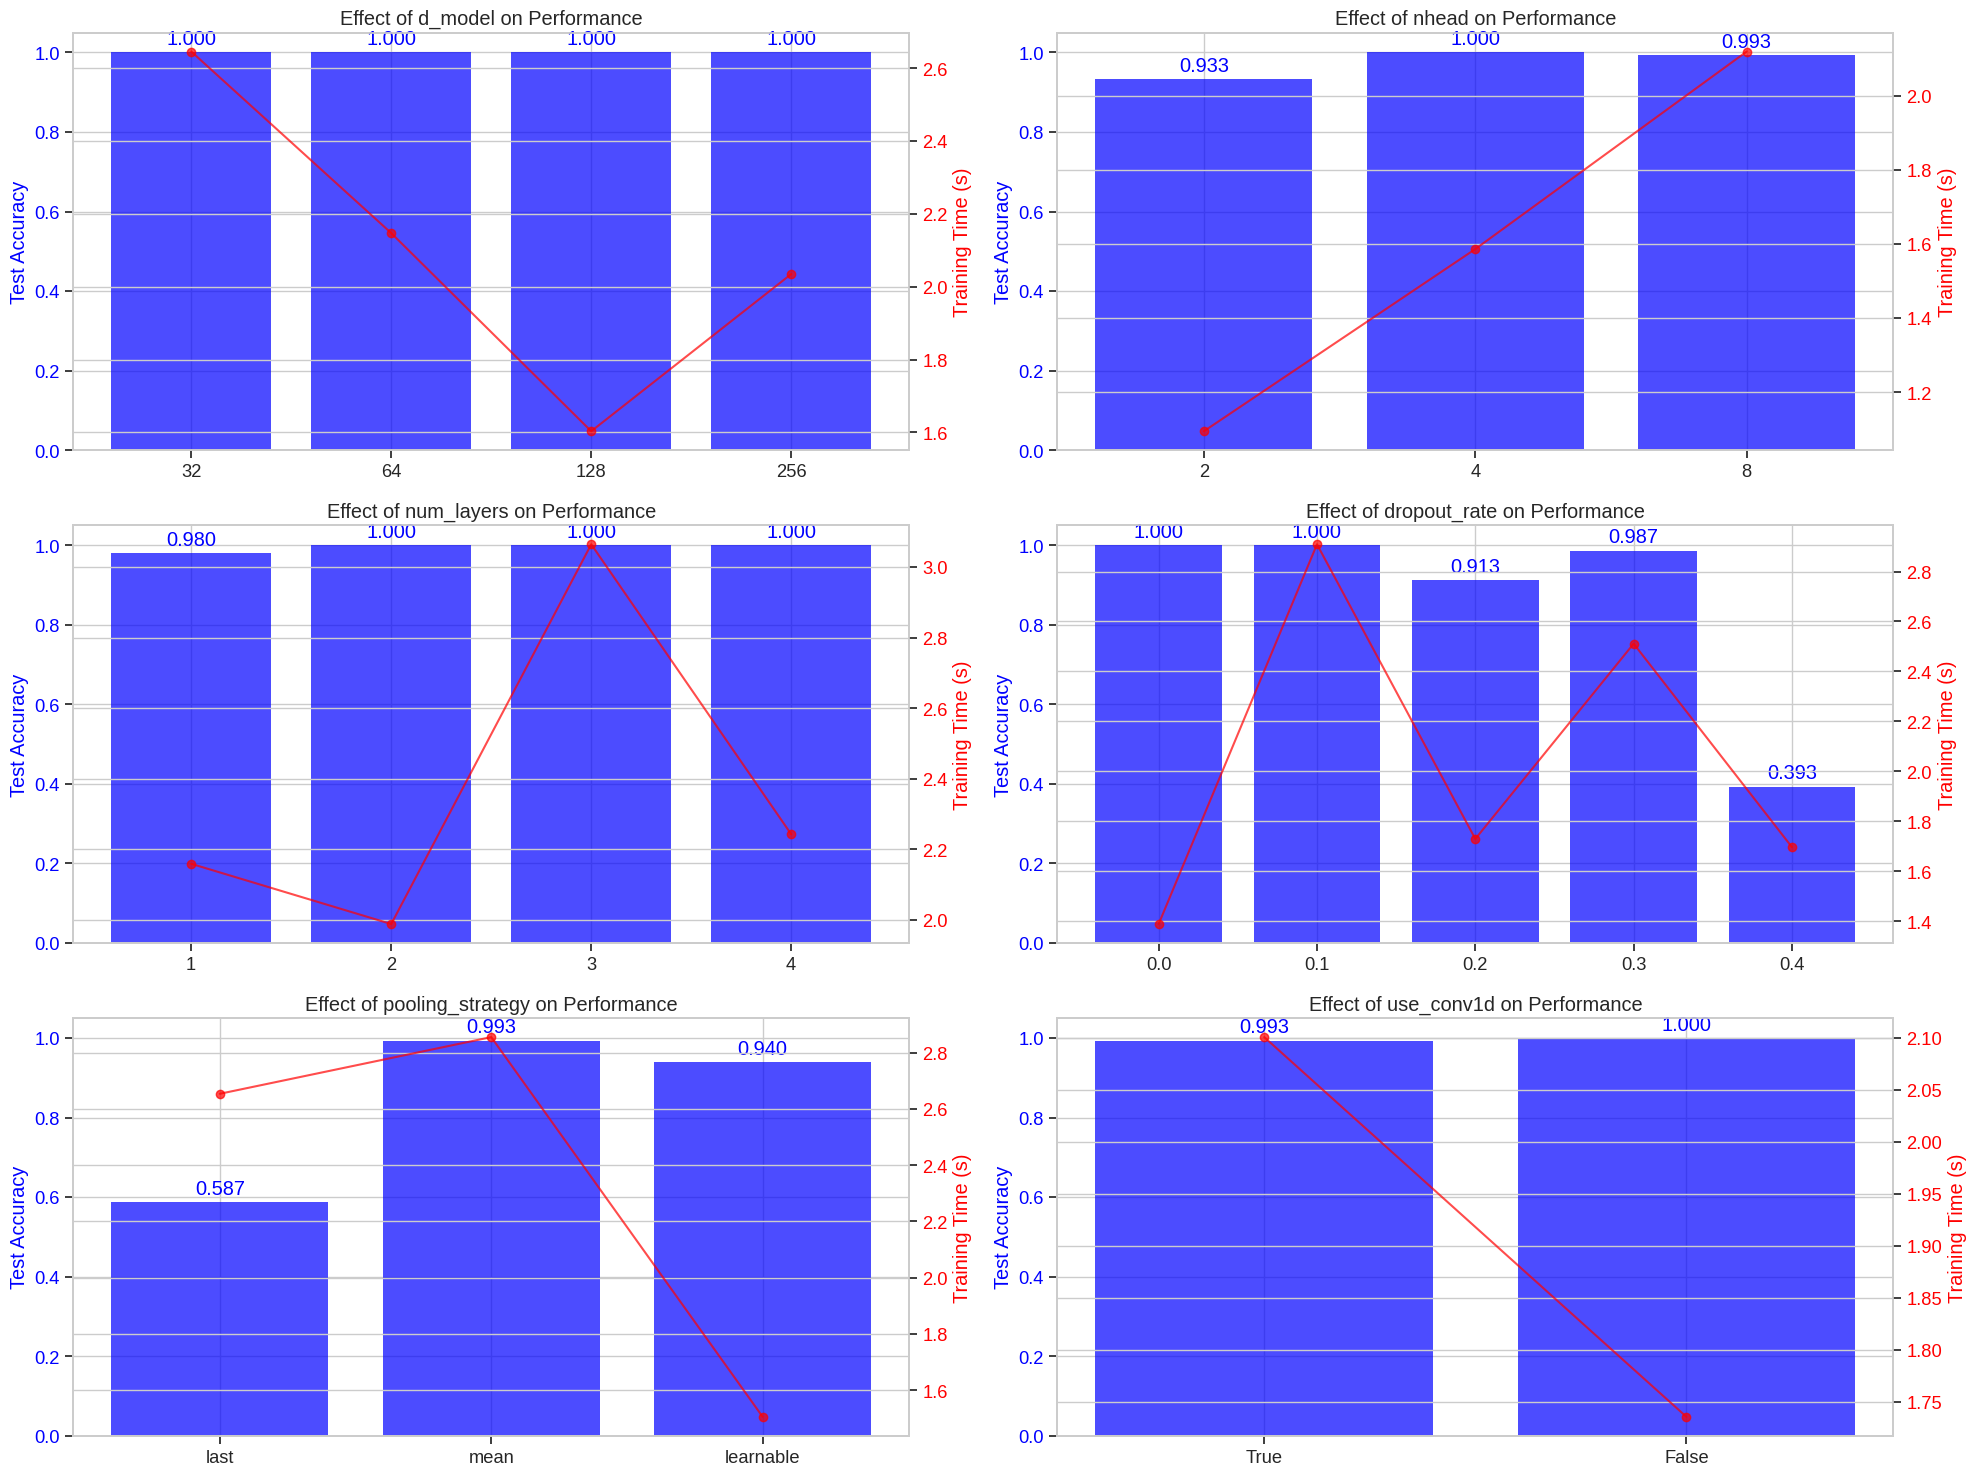

In [9]:
# Create a DataFrame from all results
all_results_df = pd.DataFrame()

for param, results in all_results.items():
    param_df = pd.DataFrame(results)
    all_results_df = pd.concat([all_results_df, param_df], ignore_index=True)

# Save results to CSV
all_results_df.to_csv('transformer_synthetic_parameter_impact.csv', index=False)

# Visualize the impact of each parameter
plt.figure(figsize=(20, 15))

for i, param in enumerate(all_results.keys()):
    # Get results for this parameter
    param_results = all_results[param]
    
    # Extract parameter values and test accuracies
    param_values = [result[param] for result in param_results]
    test_accs = [result['test_acc'] for result in param_results]
    train_times = [result['time'] for result in param_results]
    
    # Convert to strings for categorical plotting
    param_values_str = [str(val) for val in param_values]
    
    # Create subplot
    plt.subplot(3, 2, i+1)
    
    # Plot test accuracy
    ax1 = plt.gca()
    bars = ax1.bar(param_values_str, test_accs, alpha=0.7, color='blue')
    ax1.set_ylim([0, 1.05])
    ax1.set_ylabel('Test Accuracy', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', rotation=0, color='blue')
    
    # Create second y-axis for training time
    ax2 = ax1.twinx()
    ax2.plot(param_values_str, train_times, 'ro-', alpha=0.7)
    ax2.set_ylabel('Training Time (s)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    
    # Set title and labels
    plt.title(f'Effect of {param} on Performance')
    plt.xlabel(param)
    
    # Rotate x-labels if needed
    if len(param_values) > 3:
        plt.xticks(rotation=45)
        
plt.tight_layout()
plt.savefig('transformer_parameter_impact.png')
plt.show()

## 5. Combined Hyperparameter Testing

Let's also test some important combinations of hyperparameters to check for interactions.

In [10]:
# Define combinations to test
param_combinations = [
    # Test d_model and nhead combinations
    {'d_model': [64, 128], 'nhead': [2, 4, 8]},
    
    # Test dropout and num_layers combinations
    {'dropout_rate': [0.1, 0.3], 'num_layers': [1, 2, 3]},
    
    # Test pooling_strategy and use_conv1d combinations
    {'pooling_strategy': ['last', 'mean'], 'use_conv1d': [True, False]}
]

# Function to test combinations of hyperparameters
def test_parameter_combinations(param_dict, baseline, X_train, y_train, X_val, y_val, X_test, y_test):
    """
    Test combinations of hyperparameters.
    
    Args:
        param_dict: Dictionary mapping parameter names to lists of values
        baseline: Dictionary of baseline hyperparameter values
        X_train, y_train, X_val, y_val, X_test, y_test: Data
        
    Returns:
        List of results for each parameter combination
    """
    # Get parameter names and values
    param_names = list(param_dict.keys())
    param_values = [param_dict[name] for name in param_names]
    
    # Generate all combinations
    combinations = list(itertools.product(*param_values))
    
    results = []
    
    for combo in tqdm(combinations, desc=f"Testing {' x '.join(param_names)}"):
        # Create a copy of baseline parameters and update with this combination
        params = baseline.copy()
        for i, name in enumerate(param_names):
            params[name] = combo[i]
        
        # Run experiment with these parameters
        result = run_experiment(X_train, y_train, X_val, y_val, X_test, y_test, params)
        results.append(result)
    
    return results

# Run experiments for each combination
combination_results = []

for combo_dict in param_combinations:
    print(f"\nTesting combination: {' x '.join(combo_dict.keys())}")
    results = test_parameter_combinations(
        combo_dict, 
        baseline_params,
        X_train, y_train, X_val, y_val, X_test, y_test
    )
    combination_results.extend(results)
    
    # Print current results
    print(f"Results for {' x '.join(combo_dict.keys())}:")
    for result in results:
        combo_str = ', '.join([f"{k}={result[k]}" for k in combo_dict.keys()])
        print(f"  {combo_str}, Test Acc: {result['test_acc']:.4f}, Train Time: {result['time']:.2f}s")

# Create DataFrame for combination results
combo_results_df = pd.DataFrame(combination_results)

# Save combination results to CSV
combo_results_df.to_csv('transformer_synthetic_combination_results.csv', index=False)


Testing combination: d_model x nhead


Testing d_model x nhead:   0%|          | 0/6 [00:00<?, ?it/s]

🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/30], Loss: 2.0064, Train Acc: 0.3486
Validation Acc: 0.3333


/home/ianyang/stochastic_simulations/micromamba/envs/stochastic_sim/lib/python3.11/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch [2/30], Loss: 1.7030, Train Acc: 0.3629
Validation Acc: 0.3800
Epoch [3/30], Loss: 1.4527, Train Acc: 0.3443
Validation Acc: 0.4667
Epoch [4/30], Loss: 1.2946, Train Acc: 0.4129
Validation Acc: 0.6333
Epoch [5/30], Loss: 1.0941, Train Acc: 0.4943
Validation Acc: 0.8733
Epoch [6/30], Loss: 1.0201, Train Acc: 0.5471
Validation Acc: 0.9467
Epoch [7/30], Loss: 0.9441, Train Acc: 0.5971
Validation Acc: 0.9733
Epoch [8/30], Loss: 0.8155, Train Acc: 0.6829
Validation Acc: 0.9600
No improvement (1/5).
Epoch [9/30], Loss: 0.7421, Train Acc: 0.7229
Validation Acc: 1.0000
Epoch [10/30], Loss: 0.6635, Train Acc: 0.8143
Validation Acc: 1.0000
No improvement (1/5).
Epoch [11/30], Loss: 0.5555, Train Acc: 0.8657
Validation Acc: 1.0000
No improvement (2/5).
Epoch [12/30], Loss: 0.5416, Train Acc: 0.8729
Validation Acc: 1.0000
No improvement (3/5).
Epoch [13/30], Loss: 0.4970, Train Acc: 0.9057
Validation Acc: 1.0000
No improvement (4/5).


Testing d_model x nhead:  17%|█▋        | 1/6 [00:01<00:09,  1.91s/it]

Epoch [14/30], Loss: 0.4750, Train Acc: 0.9200
Validation Acc: 1.0000
No improvement (5/5).
Stopping early! No improvement for 5 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/30], Loss: 3.1786, Train Acc: 0.3400
Validation Acc: 0.3333
Epoch [2/30], Loss: 2.4887, Train Acc: 0.3586
Validation Acc: 0.3333
No improvement (1/5).
Epoch [3/30], Loss: 1.4428, Train Acc: 0.4186
Validation Acc: 0.3467
Epoch [4/30], Loss: 1.1815, Train Acc: 0.4600
Validation Acc: 0.6200
Epoch [5/30], Loss: 0.9866, Train Acc: 0.5571
Validation Acc: 0.5867
No improvement (1/5).
Epoch [6/30], Loss: 0.8996, Train Acc: 0.6200
Validation Acc: 0.7667
Epoch [7/30], Loss: 0.8642, Train Acc: 0.6357
Validation Acc: 0.7600
No improvement (1/5).
Epoch [8/30], Loss: 0.8091, Train Acc: 0.6629
Validation Acc: 0.8267
Epoch [9/30], Loss: 0.7183, Train Acc: 0.7514
Validation Acc: 0.8800
Epoch [10/30], Loss: 0.6568, Train Acc: 0.7829
Validation Acc: 

Testing d_model x nhead:  33%|███▎      | 2/6 [00:05<00:10,  2.69s/it]

Epoch [24/30], Loss: 0.4112, Train Acc: 0.9629
Validation Acc: 0.9933
No improvement (5/5).
Stopping early! No improvement for 5 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/30], Loss: 1.8053, Train Acc: 0.3100
Validation Acc: 0.3333
Epoch [2/30], Loss: 1.5907, Train Acc: 0.3043
Validation Acc: 0.2467
No improvement (1/5).
Epoch [3/30], Loss: 1.3618, Train Acc: 0.3443
Validation Acc: 0.3267
No improvement (2/5).
Epoch [4/30], Loss: 1.1895, Train Acc: 0.4114
Validation Acc: 0.5200
Epoch [5/30], Loss: 1.0595, Train Acc: 0.4843
Validation Acc: 0.7133
Epoch [6/30], Loss: 0.9354, Train Acc: 0.5657
Validation Acc: 0.8867
Epoch [7/30], Loss: 0.8367, Train Acc: 0.6600
Validation Acc: 0.9400
Epoch [8/30], Loss: 0.7624, Train Acc: 0.7171
Validation Acc: 0.9600
Epoch [9/30], Loss: 0.6780, Train Acc: 0.7757
Validation Acc: 0.9800
Epoch [10/30], Loss: 0.6669, Train Acc: 0.7729
Validation Acc: 0.9400
No improvement 

Testing d_model x nhead:  50%|█████     | 3/6 [00:07<00:07,  2.43s/it]

Epoch [16/30], Loss: 0.4710, Train Acc: 0.9343
Validation Acc: 1.0000
No improvement (5/5).
Stopping early! No improvement for 5 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/30], Loss: 2.6454, Train Acc: 0.3386
Validation Acc: 0.3333
Epoch [2/30], Loss: 1.7652, Train Acc: 0.3629
Validation Acc: 0.4133
Epoch [3/30], Loss: 1.0901, Train Acc: 0.4700
Validation Acc: 0.9467
Epoch [4/30], Loss: 0.8659, Train Acc: 0.6186
Validation Acc: 0.9600
Epoch [5/30], Loss: 0.6744, Train Acc: 0.7900
Validation Acc: 1.0000
Epoch [6/30], Loss: 0.5778, Train Acc: 0.8757
Validation Acc: 0.9933
No improvement (1/5).
Epoch [7/30], Loss: 0.4576, Train Acc: 0.9371
Validation Acc: 1.0000
No improvement (2/5).
Epoch [8/30], Loss: 0.4114, Train Acc: 0.9686
Validation Acc: 1.0000
No improvement (3/5).
Epoch [9/30], Loss: 0.3794, Train Acc: 0.9843
Validation Acc: 1.0000
No improvement (4/5).


Testing d_model x nhead:  67%|██████▋   | 4/6 [00:08<00:03,  2.00s/it]

Epoch [10/30], Loss: 0.3671, Train Acc: 0.9886
Validation Acc: 1.0000
No improvement (5/5).
Stopping early! No improvement for 5 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/30], Loss: 1.4678, Train Acc: 0.3414
Validation Acc: 0.3067
Epoch [2/30], Loss: 1.3049, Train Acc: 0.3843
Validation Acc: 0.6200
Epoch [3/30], Loss: 0.9956, Train Acc: 0.5429
Validation Acc: 0.9267
Epoch [4/30], Loss: 0.7213, Train Acc: 0.7400
Validation Acc: 0.9933
Epoch [5/30], Loss: 0.5817, Train Acc: 0.8514
Validation Acc: 0.9933
No improvement (1/5).
Epoch [6/30], Loss: 0.5148, Train Acc: 0.9100
Validation Acc: 1.0000
Epoch [7/30], Loss: 0.4587, Train Acc: 0.9386
Validation Acc: 1.0000
No improvement (1/5).
Epoch [8/30], Loss: 0.4035, Train Acc: 0.9757
Validation Acc: 1.0000
No improvement (2/5).
Epoch [9/30], Loss: 0.3886, Train Acc: 0.9786
Validation Acc: 1.0000
No improvement (3/5).


Testing d_model x nhead:  83%|████████▎ | 5/6 [00:10<00:01,  1.81s/it]

Epoch [10/30], Loss: 0.3695, Train Acc: 0.9857
Validation Acc: 1.0000
No improvement (4/5).
Epoch [11/30], Loss: 0.3473, Train Acc: 0.9957
Validation Acc: 1.0000
No improvement (5/5).
Stopping early! No improvement for 5 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/30], Loss: 1.8129, Train Acc: 0.2929
Validation Acc: 0.3333
Epoch [2/30], Loss: 1.5020, Train Acc: 0.2929
Validation Acc: 0.3333
No improvement (1/5).
Epoch [3/30], Loss: 1.1212, Train Acc: 0.4571
Validation Acc: 0.9000
Epoch [4/30], Loss: 0.8513, Train Acc: 0.6386
Validation Acc: 0.9667
Epoch [5/30], Loss: 0.6752, Train Acc: 0.7700
Validation Acc: 0.9533
No improvement (1/5).
Epoch [6/30], Loss: 0.6111, Train Acc: 0.8100
Validation Acc: 0.9933
Epoch [7/30], Loss: 0.5347, Train Acc: 0.9043
Validation Acc: 0.9933
No improvement (1/5).
Epoch [8/30], Loss: 0.4853, Train Acc: 0.9186
Validation Acc: 1.0000
Epoch [9/30], Loss: 0.4446, Train Acc: 0

Testing d_model x nhead: 100%|██████████| 6/6 [00:11<00:00,  1.98s/it]


Epoch [13/30], Loss: 0.3866, Train Acc: 0.9786
Validation Acc: 1.0000
No improvement (5/5).
Stopping early! No improvement for 5 epochs.
Training complete!
Results for d_model x nhead:
  d_model=64, nhead=2, Test Acc: 1.0000, Train Time: 1.91s
  d_model=64, nhead=4, Test Acc: 0.9933, Train Time: 3.23s
  d_model=64, nhead=8, Test Acc: 1.0000, Train Time: 2.12s
  d_model=128, nhead=2, Test Acc: 1.0000, Train Time: 1.34s
  d_model=128, nhead=4, Test Acc: 1.0000, Train Time: 1.48s
  d_model=128, nhead=8, Test Acc: 1.0000, Train Time: 1.78s

Testing combination: dropout_rate x num_layers


Testing dropout_rate x num_layers:   0%|          | 0/6 [00:00<?, ?it/s]

🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/30], Loss: 1.6995, Train Acc: 0.3443
Validation Acc: 0.3333
Epoch [2/30], Loss: 1.5216, Train Acc: 0.3314
Validation Acc: 0.3333
No improvement (1/5).
Epoch [3/30], Loss: 1.3268, Train Acc: 0.3043
Validation Acc: 0.3200
No improvement (2/5).
Epoch [4/30], Loss: 1.2142, Train Acc: 0.3543
Validation Acc: 0.4733
Epoch [5/30], Loss: 1.0609, Train Acc: 0.4757
Validation Acc: 0.8400
Epoch [6/30], Loss: 1.0365, Train Acc: 0.5000
Validation Acc: 0.9467
Epoch [7/30], Loss: 0.9461, Train Acc: 0.5800
Validation Acc: 0.9533
Epoch [8/30], Loss: 0.8604, Train Acc: 0.6600
Validation Acc: 0.9733
Epoch [9/30], Loss: 0.8362, Train Acc: 0.6700
Validation Acc: 0.9533
No improvement (1/5).
Epoch [10/30], Loss: 0.7786, Train Acc: 0.7143
Validation Acc: 0.9933
Epoch [11/30], Loss: 0.7111, Train Acc: 0.7643
Validation Acc: 0.9733
No improvement (1/5).
Epoch [12/30], Loss: 0.6655, Train Acc: 0.8057
Validation

Testing dropout_rate x num_layers:  17%|█▋        | 1/6 [00:01<00:08,  1.66s/it]

Epoch [17/30], Loss: 0.5282, Train Acc: 0.9171
Validation Acc: 1.0000
No improvement (5/5).
Stopping early! No improvement for 5 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/30], Loss: 2.4752, Train Acc: 0.3286
Validation Acc: 0.3333
Epoch [2/30], Loss: 1.8899, Train Acc: 0.3314
Validation Acc: 0.2800
No improvement (1/5).
Epoch [3/30], Loss: 1.1632, Train Acc: 0.4000
Validation Acc: 0.8867
Epoch [4/30], Loss: 0.9006, Train Acc: 0.6014
Validation Acc: 0.9467
Epoch [5/30], Loss: 0.7169, Train Acc: 0.7543
Validation Acc: 0.9600
Epoch [6/30], Loss: 0.6346, Train Acc: 0.8286
Validation Acc: 0.9933
Epoch [7/30], Loss: 0.5590, Train Acc: 0.8814
Validation Acc: 0.9933
No improvement (1/5).
Epoch [8/30], Loss: 0.5094, Train Acc: 0.9100
Validation Acc: 1.0000
Epoch [9/30], Loss: 0.4713, Train Acc: 0.9429
Validation Acc: 1.0000
No improvement (1/5).
Epoch [10/30], Loss: 0.4443, Train Acc: 0.9471
Validation Acc: 

Testing dropout_rate x num_layers:  33%|███▎      | 2/6 [00:03<00:06,  1.70s/it]

Epoch [12/30], Loss: 0.4383, Train Acc: 0.9514
Validation Acc: 1.0000
No improvement (4/5).
Epoch [13/30], Loss: 0.4293, Train Acc: 0.9629
Validation Acc: 1.0000
No improvement (5/5).
Stopping early! No improvement for 5 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/30], Loss: 3.3385, Train Acc: 0.3314
Validation Acc: 0.3333
Epoch [2/30], Loss: 2.5095, Train Acc: 0.3371
Validation Acc: 0.2000
No improvement (1/5).
Epoch [3/30], Loss: 1.5632, Train Acc: 0.3714
Validation Acc: 0.4667
Epoch [4/30], Loss: 1.2452, Train Acc: 0.4471
Validation Acc: 0.9133
Epoch [5/30], Loss: 1.0298, Train Acc: 0.5543
Validation Acc: 0.9733
Epoch [6/30], Loss: 0.8616, Train Acc: 0.6243
Validation Acc: 0.9867
Epoch [7/30], Loss: 0.7334, Train Acc: 0.7357
Validation Acc: 1.0000
Epoch [8/30], Loss: 0.6472, Train Acc: 0.8043
Validation Acc: 1.0000
No improvement (1/5).
Epoch [9/30], Loss: 0.5730, Train Acc: 0.8586
Validation Acc: 

Testing dropout_rate x num_layers:  50%|█████     | 3/6 [00:05<00:05,  1.85s/it]

Epoch [11/30], Loss: 0.5017, Train Acc: 0.9143
Validation Acc: 0.9867
No improvement (4/5).
Epoch [12/30], Loss: 0.4878, Train Acc: 0.9200
Validation Acc: 0.9867
No improvement (5/5).
Stopping early! No improvement for 5 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/30], Loss: 3.6059, Train Acc: 0.3314
Validation Acc: 0.3333
Epoch [2/30], Loss: 3.3078, Train Acc: 0.3371
Validation Acc: 0.4533
Epoch [3/30], Loss: 2.7710, Train Acc: 0.3471
Validation Acc: 0.5000
Epoch [4/30], Loss: 2.1113, Train Acc: 0.3443
Validation Acc: 0.5533
Epoch [5/30], Loss: 1.7248, Train Acc: 0.3600
Validation Acc: 0.5400
No improvement (1/5).
Epoch [6/30], Loss: 1.4612, Train Acc: 0.3743
Validation Acc: 0.5867
Epoch [7/30], Loss: 1.2049, Train Acc: 0.4486
Validation Acc: 0.6667
Epoch [8/30], Loss: 1.1492, Train Acc: 0.4514
Validation Acc: 0.6867
Epoch [9/30], Loss: 1.0884, Train Acc: 0.4943
Validation Acc: 0.7800
Epoch [10/30], 

Testing dropout_rate x num_layers:  67%|██████▋   | 4/6 [00:07<00:04,  2.13s/it]

Epoch [25/30], Loss: 0.7615, Train Acc: 0.7143
Validation Acc: 0.9133
No improvement (4/5).
Epoch [26/30], Loss: 0.7722, Train Acc: 0.6943
Validation Acc: 0.9000
No improvement (5/5).
Stopping early! No improvement for 5 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/30], Loss: 2.3532, Train Acc: 0.3486
Validation Acc: 0.3333
Epoch [2/30], Loss: 2.2172, Train Acc: 0.3614
Validation Acc: 0.4400
Epoch [3/30], Loss: 1.9703, Train Acc: 0.3557
Validation Acc: 0.4200
No improvement (1/5).
Epoch [4/30], Loss: 1.6308, Train Acc: 0.3557
Validation Acc: 0.5800
Epoch [5/30], Loss: 1.5638, Train Acc: 0.3671
Validation Acc: 0.7000
Epoch [6/30], Loss: 1.3424, Train Acc: 0.4086
Validation Acc: 0.8200
Epoch [7/30], Loss: 1.3126, Train Acc: 0.4100
Validation Acc: 0.9467
Epoch [8/30], Loss: 1.2439, Train Acc: 0.3857
Validation Acc: 0.9267
No improvement (1/5).
Epoch [9/30], Loss: 1.1484, Train Acc: 0.4629
Validation Acc: 

Testing dropout_rate x num_layers:  83%|████████▎ | 5/6 [00:09<00:01,  1.94s/it]

Epoch [11/30], Loss: 1.0954, Train Acc: 0.4671
Validation Acc: 0.9333
No improvement (4/5).
Epoch [12/30], Loss: 1.0187, Train Acc: 0.5186
Validation Acc: 0.8867
No improvement (5/5).
Stopping early! No improvement for 5 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/30], Loss: 2.9954, Train Acc: 0.3271
Validation Acc: 0.3333
Epoch [2/30], Loss: 2.4846, Train Acc: 0.3871
Validation Acc: 0.3267
No improvement (1/5).
Epoch [3/30], Loss: 2.1091, Train Acc: 0.3357
Validation Acc: 0.3533
Epoch [4/30], Loss: 1.7572, Train Acc: 0.3543
Validation Acc: 0.6067
Epoch [5/30], Loss: 1.5371, Train Acc: 0.4043
Validation Acc: 0.6733
Epoch [6/30], Loss: 1.3863, Train Acc: 0.4100
Validation Acc: 0.6600
No improvement (1/5).
Epoch [7/30], Loss: 1.3157, Train Acc: 0.4057
Validation Acc: 0.6600
No improvement (2/5).
Epoch [8/30], Loss: 1.1712, Train Acc: 0.4514
Validation Acc: 0.7467
Epoch [9/30], Loss: 1.1322, Train Acc: 0

Testing dropout_rate x num_layers: 100%|██████████| 6/6 [00:12<00:00,  2.04s/it]


Epoch [15/30], Loss: 0.9002, Train Acc: 0.5971
Validation Acc: 0.7267
No improvement (4/5).
Epoch [16/30], Loss: 0.8689, Train Acc: 0.6229
Validation Acc: 0.7467
No improvement (5/5).
Stopping early! No improvement for 5 epochs.
Training complete!
Results for dropout_rate x num_layers:
  dropout_rate=0.1, num_layers=1, Test Acc: 1.0000, Train Time: 1.66s
  dropout_rate=0.1, num_layers=2, Test Acc: 0.9933, Train Time: 1.73s
  dropout_rate=0.1, num_layers=3, Test Acc: 1.0000, Train Time: 2.02s
  dropout_rate=0.3, num_layers=1, Test Acc: 0.9333, Train Time: 2.55s
  dropout_rate=0.3, num_layers=2, Test Acc: 0.8933, Train Time: 1.62s
  dropout_rate=0.3, num_layers=3, Test Acc: 0.7667, Train Time: 2.68s

Testing combination: pooling_strategy x use_conv1d


Testing pooling_strategy x use_conv1d:   0%|          | 0/4 [00:00<?, ?it/s]

🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/30], Loss: 3.0939, Train Acc: 0.3014
Validation Acc: 0.3333
Epoch [2/30], Loss: 3.0552, Train Acc: 0.3314
Validation Acc: 0.3467
Epoch [3/30], Loss: 2.4882, Train Acc: 0.3414
Validation Acc: 0.3400
No improvement (1/5).
Epoch [4/30], Loss: 2.2399, Train Acc: 0.3671
Validation Acc: 0.3400
No improvement (2/5).
Epoch [5/30], Loss: 2.1545, Train Acc: 0.3329
Validation Acc: 0.3467
No improvement (3/5).
Epoch [6/30], Loss: 1.9984, Train Acc: 0.3414
Validation Acc: 0.3933
Epoch [7/30], Loss: 1.8478, Train Acc: 0.3800
Validation Acc: 0.3867
No improvement (1/5).
Epoch [8/30], Loss: 1.9182, Train Acc: 0.3571
Validation Acc: 0.3533
No improvement (2/5).
Epoch [9/30], Loss: 1.7247, Train Acc: 0.3929
Validation Acc: 0.3867
No improvement (3/5).
Epoch [10/30], Loss: 1.7085, Train Acc: 0.3571
Validation Acc: 0.4067
Epoch [11/30], Loss: 1.7110, Train Acc: 0.3571
Validation Acc: 0.4467
Epoch [12/30]

Testing pooling_strategy x use_conv1d:  25%|██▌       | 1/4 [00:03<00:11,  3.92s/it]

Epoch [29/30], Loss: 1.3448, Train Acc: 0.4343
Validation Acc: 0.5867
No improvement (5/5).
Stopping early! No improvement for 5 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/30], Loss: 7.4380, Train Acc: 0.3343
Validation Acc: 0.3333
Epoch [2/30], Loss: 6.4549, Train Acc: 0.3400
Validation Acc: 0.3333
No improvement (1/5).
Epoch [3/30], Loss: 4.1994, Train Acc: 0.3371
Validation Acc: 0.3267
No improvement (2/5).
Epoch [4/30], Loss: 2.4957, Train Acc: 0.3371
Validation Acc: 0.3267
No improvement (3/5).
Epoch [5/30], Loss: 1.8009, Train Acc: 0.3743
Validation Acc: 0.3667
Epoch [6/30], Loss: 1.8008, Train Acc: 0.3286
Validation Acc: 0.4000
Epoch [7/30], Loss: 1.7380, Train Acc: 0.3214
Validation Acc: 0.3867
No improvement (1/5).
Epoch [8/30], Loss: 1.6062, Train Acc: 0.3514
Validation Acc: 0.3600
No improvement (2/5).
Epoch [9/30], Loss: 1.5993, Train Acc: 0.3414
Validation Acc: 0.3600
No improvement (3/5

Testing pooling_strategy x use_conv1d:  50%|█████     | 2/4 [00:05<00:04,  2.37s/it]

Epoch [11/30], Loss: 1.4839, Train Acc: 0.3700
Validation Acc: 0.3467
No improvement (5/5).
Stopping early! No improvement for 5 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/30], Loss: 1.4018, Train Acc: 0.3757
Validation Acc: 0.3333
Epoch [2/30], Loss: 1.2582, Train Acc: 0.4171
Validation Acc: 0.3467
Epoch [3/30], Loss: 1.1290, Train Acc: 0.4514
Validation Acc: 0.7933
Epoch [4/30], Loss: 0.9822, Train Acc: 0.5429
Validation Acc: 0.8667
Epoch [5/30], Loss: 0.8741, Train Acc: 0.6243
Validation Acc: 0.8600
No improvement (1/5).
Epoch [6/30], Loss: 0.7871, Train Acc: 0.7114
Validation Acc: 0.9333
Epoch [7/30], Loss: 0.7099, Train Acc: 0.7643
Validation Acc: 0.8733
No improvement (1/5).
Epoch [8/30], Loss: 0.6730, Train Acc: 0.7857
Validation Acc: 0.9533
Epoch [9/30], Loss: 0.6120, Train Acc: 0.8229
Validation Acc: 0.9467
No improvement (1/5).
Epoch [10/30], Loss: 0.5886, Train Acc: 0.8486
Validation Acc: 

Testing pooling_strategy x use_conv1d:  75%|███████▌  | 3/4 [00:07<00:02,  2.51s/it]

Epoch [20/30], Loss: 0.4187, Train Acc: 0.9514
Validation Acc: 0.9933
No improvement (5/5).
Stopping early! No improvement for 5 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/30], Loss: 1.9035, Train Acc: 0.3500
Validation Acc: 0.3333
Epoch [2/30], Loss: 1.4790, Train Acc: 0.3829
Validation Acc: 0.6600
Epoch [3/30], Loss: 1.2070, Train Acc: 0.4200
Validation Acc: 0.9933
Epoch [4/30], Loss: 1.0586, Train Acc: 0.4914
Validation Acc: 0.9733
No improvement (1/5).
Epoch [5/30], Loss: 0.9576, Train Acc: 0.5543
Validation Acc: 1.0000
Epoch [6/30], Loss: 0.8188, Train Acc: 0.6743
Validation Acc: 1.0000
No improvement (1/5).
Epoch [7/30], Loss: 0.6820, Train Acc: 0.8029
Validation Acc: 1.0000
No improvement (2/5).
Epoch [8/30], Loss: 0.6290, Train Acc: 0.8271
Validation Acc: 1.0000
No improvement (3/5).
Epoch [9/30], Loss: 0.5296, Train Acc: 0.8886
Validation Acc: 1.0000
No improvement (4/5).


Testing pooling_strategy x use_conv1d: 100%|██████████| 4/4 [00:09<00:00,  2.27s/it]

Epoch [10/30], Loss: 0.4906, Train Acc: 0.9143
Validation Acc: 1.0000
No improvement (5/5).
Stopping early! No improvement for 5 epochs.
Training complete!
Results for pooling_strategy x use_conv1d:
  pooling_strategy=last, use_conv1d=True, Test Acc: 0.5467, Train Time: 3.92s
  pooling_strategy=last, use_conv1d=False, Test Acc: 0.3333, Train Time: 1.29s
  pooling_strategy=mean, use_conv1d=True, Test Acc: 0.9933, Train Time: 2.68s
  pooling_strategy=mean, use_conv1d=False, Test Acc: 1.0000, Train Time: 1.18s


## 6. Visualize Parameter Interactions

Let's create heatmaps to visualize how parameters interact with each other.

/tmp/ipykernel_233473/457511995.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pivot_data[param2] = pivot_data[param2].astype(int)


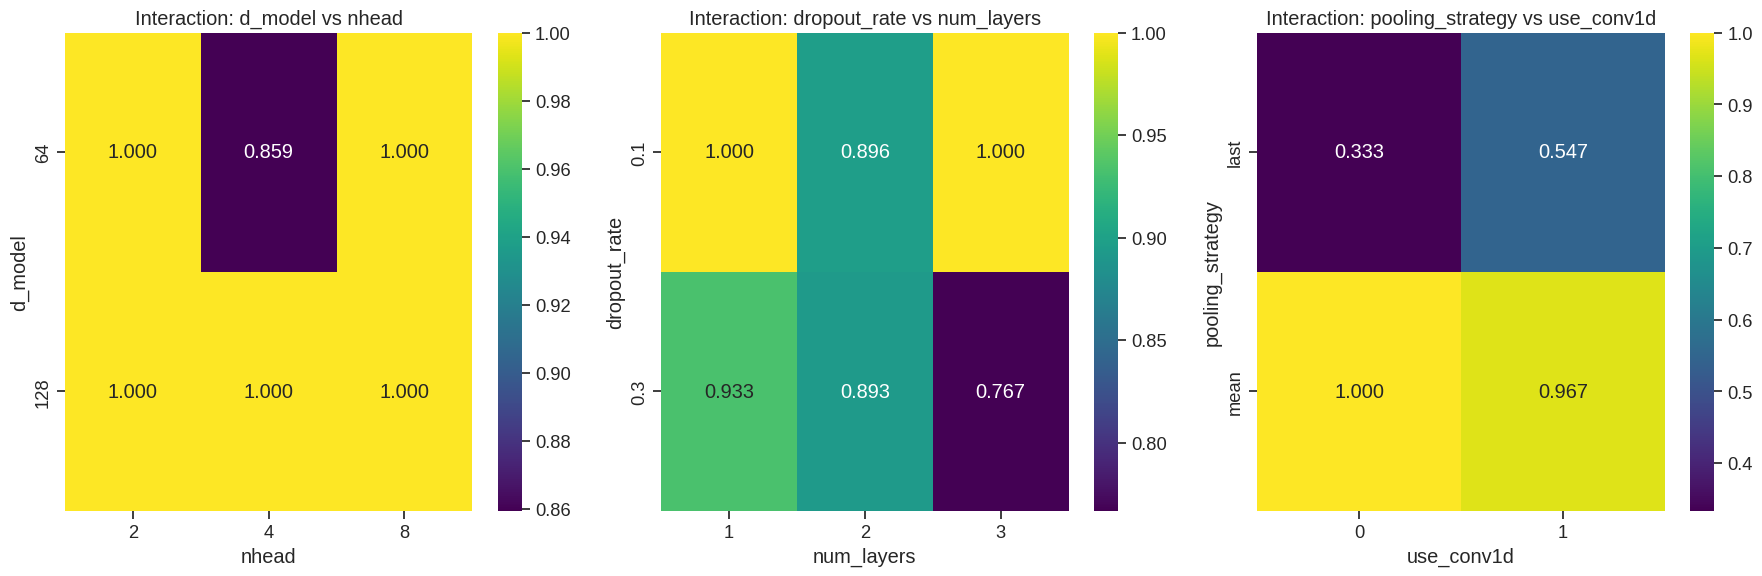

In [11]:
# Visualize parameter interactions with heatmaps
plt.figure(figsize=(18, 6))

# Parameters to visualize
param_pairs = [
    ('d_model', 'nhead'),
    ('dropout_rate', 'num_layers'),
    ('pooling_strategy', 'use_conv1d')
]

for i, (param1, param2) in enumerate(param_pairs):
    # Create a pivot table for this pair
    try:
        pivot_data = combo_results_df[[param1, param2, 'test_acc']]
        # Convert boolean to int for proper pivoting
        if pivot_data[param2].dtype == bool:
            pivot_data[param2] = pivot_data[param2].astype(int)
        if pivot_data[param1].dtype == bool:
            pivot_data[param1] = pivot_data[param1].astype(int)
            
        pivot = pivot_data.pivot_table(
            values='test_acc', 
            index=param1, 
            columns=param2, 
            aggfunc='mean'
        )
        
        # Plot heatmap
        plt.subplot(1, 3, i+1)
        sns.heatmap(pivot, annot=True, cmap='viridis', fmt='.3f', cbar=True)
        plt.title(f'Interaction: {param1} vs {param2}')
    except Exception as e:
        print(f"Error creating heatmap for {param1} vs {param2}: {e}")
        plt.subplot(1, 3, i+1)
        plt.text(0.5, 0.5, f"Error: {str(e)}", ha='center', va='center')
        plt.title(f'Error: {param1} vs {param2}')

plt.tight_layout()
plt.savefig('transformer_parameter_interactions.png')
plt.show()

## 7. Final Analysis and Conclusions

Let's rank the parameters by their impact on test accuracy and summarize our findings.

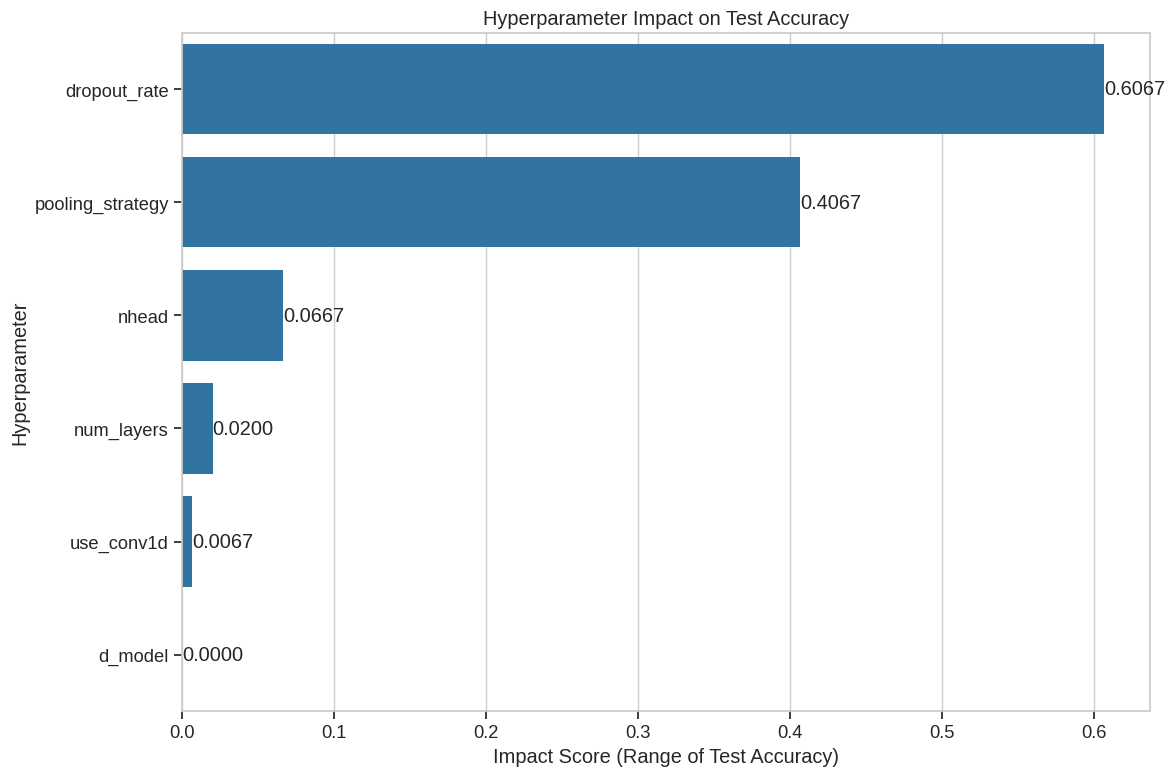

Hyperparameter Impact Ranking:
1. dropout_rate: 0.6067
2. pooling_strategy: 0.4067
3. nhead: 0.0667
4. num_layers: 0.0200
5. use_conv1d: 0.0067
6. d_model: 0.0000

Best configuration found:
d_model: 32
nhead: 4
num_layers: 2
dropout_rate: 0.1
learning_rate: 0.001
batch_size: 32
optimizer: Adam
pooling_strategy: mean
use_conv1d: True
gradient_clip: 1.0
Test Accuracy: 1.0000
Training Time: 2.65s

Key Findings:
1. Most important parameters (in order):
   - dropout_rate (impact: 0.6067)
   - pooling_strategy (impact: 0.4067)
   - nhead (impact: 0.0667)
   - num_layers (impact: 0.0200)
   - use_conv1d (impact: 0.0067)

2. Best parameter values for synthetic cosine data:
   - dropout_rate: 0.0 (accuracy: 1.0000)
   - pooling_strategy: mean (accuracy: 0.9933)
   - nhead: 4 (accuracy: 1.0000)
   - num_layers: 2 (accuracy: 1.0000)
   - use_conv1d: False (accuracy: 1.0000)
   - d_model: 32 (accuracy: 1.0000)

3. Parameter interactions:
   - Analyze the heatmaps above to understand how parameters

In [19]:
# Calculate parameter impact scores
param_impacts = {}

for param, results in all_results.items():
    try:
        # Calculate mean test accuracy for each parameter value
        values = [result[param] for result in results]
        accs = [result['test_acc'] for result in results]
        
        if len(accs) < 2:
            print(f"Warning: Not enough data points for {param}, skipping impact calculation")
            continue
            
        # Calculate range of accuracy values (max - min)
        acc_range = max(accs) - min(accs)
        
        # Store impact score
        param_impacts[param] = acc_range
    except Exception as e:
        print(f"Error calculating impact for {param}: {e}")
        param_impacts[param] = 0.0

# Create a DataFrame for impact scores
impact_df = pd.DataFrame({
    'Parameter': list(param_impacts.keys()),
    'Impact Score': list(param_impacts.values())
})
impact_df = impact_df.sort_values('Impact Score', ascending=False)

# Plot impact scores
plt.figure(figsize=(12, 8))
sns.barplot(x='Impact Score', y='Parameter', data=impact_df)
# show the impact scores on the bars
for index, value in enumerate(impact_df['Impact Score']):
    plt.text(value, index, f"{value:.4f}", va='center')
plt.title('Hyperparameter Impact on Test Accuracy')
plt.xlabel('Impact Score (Range of Test Accuracy)')
plt.ylabel('Hyperparameter')
plt.tight_layout()
plt.savefig('transformer_parameter_impact_ranking.png')
plt.show()

# Print impact ranking
print("Hyperparameter Impact Ranking:")
for i, (param, impact) in enumerate(zip(impact_df['Parameter'], impact_df['Impact Score'])):
    print(f"{i+1}. {param}: {impact:.4f}")

# Find the best configuration from all experiments
try:
    all_combined_results = pd.concat([all_results_df, combo_results_df], ignore_index=True)
    if len(all_combined_results) > 0:
        best_config = all_combined_results.loc[all_combined_results['test_acc'].idxmax()]
        
        print("\nBest configuration found:")
        for param in baseline_params.keys():
            if param in best_config:
                print(f"{param}: {best_config[param]}")
        print(f"Test Accuracy: {best_config['test_acc']:.4f}")
        print(f"Training Time: {best_config['time']:.2f}s")
    else:
        print("\nNo results available to find best configuration")
except Exception as e:
    print(f"\nError finding best configuration: {e}")
    print("This may occur if no experiments were run successfully")

# Summary of findings
print("\nKey Findings:")
print("1. Most important parameters (in order):")
if len(impact_df) > 0:
    for i in range(min(5, len(impact_df))):
        param = impact_df.iloc[i]['Parameter']
        impact = impact_df.iloc[i]['Impact Score']
        print(f"   - {param} (impact: {impact:.4f})")
else:
    print("   No parameter impact data available")

print("\n2. Best parameter values for synthetic cosine data:")
for param in impact_df['Parameter'] if not impact_df.empty else []:
    try:
        param_results = all_results.get(param, [])
        if param_results:
            best_result = max(param_results, key=lambda x: x['test_acc'])
            best_value = best_result[param]
            best_acc = best_result['test_acc']
            print(f"   - {param}: {best_value} (accuracy: {best_acc:.4f})")
    except Exception as e:
        print(f"   - Error analyzing {param}: {e}")

print("\n3. Parameter interactions:")
print("   - Analyze the heatmaps above to understand how parameters interact")
print("   - Pay special attention to pooling_strategy and use_conv1d interaction")

print("\n4. Comparison with real data findings:")
print("   - Compare these results with your grid search on real data (IY006B.csv)")
print("   - Look for differences in parameter importance rankings")
print("   - Note whether synthetic data findings generalize to real-world data")

In [13]:
# Check environment setup and required packages
import sys
import importlib
import os

# Verify Python environment
print(f"Python version: {sys.version}")

# Check project path
project_path = '/home/ianyang/stochastic_simulations'
print(f"Project path exists: {os.path.exists(project_path)}")
print(f"Models directory exists: {os.path.exists(os.path.join(project_path, 'src', 'models'))}")

# Check required packages
required_packages = ['numpy', 'pandas', 'matplotlib', 'seaborn', 'torch', 'sklearn', 'tqdm']
missing_packages = []

for package in required_packages:
    try:
        importlib.import_module(package)
        print(f"✓ {package} is installed")
    except ImportError:
        missing_packages.append(package)
        print(f"✗ {package} is NOT installed")

if missing_packages:
    print(f"\nWarning: The following packages are missing: {', '.join(missing_packages)}")
    print("Please install them before running this notebook.")
else:
    print("\nAll required packages are installed!")

# Check if TransformerClassifier can be imported
try:
    # Try both import paths
    try:
        from src.models.transformer import TransformerClassifier
        print("✓ TransformerClassifier imported from src.models.transformer")
    except ImportError:
        from models.transformer import TransformerClassifier
        print("✓ TransformerClassifier imported from models.transformer")
    print("TransformerClassifier available!")
except ImportError:
    print("✗ Failed to import TransformerClassifier. Check your import paths.")

Python version: 3.11.11 | packaged by conda-forge | (main, Dec  5 2024, 14:17:24) [GCC 13.3.0]
Project path exists: True
Models directory exists: True
✓ numpy is installed
✓ pandas is installed
✓ matplotlib is installed
✓ seaborn is installed
✓ torch is installed
✓ sklearn is installed
✓ tqdm is installed

All required packages are installed!
✓ TransformerClassifier imported from src.models.transformer
TransformerClassifier available!



--- Performance vs. Training Time Analysis ---


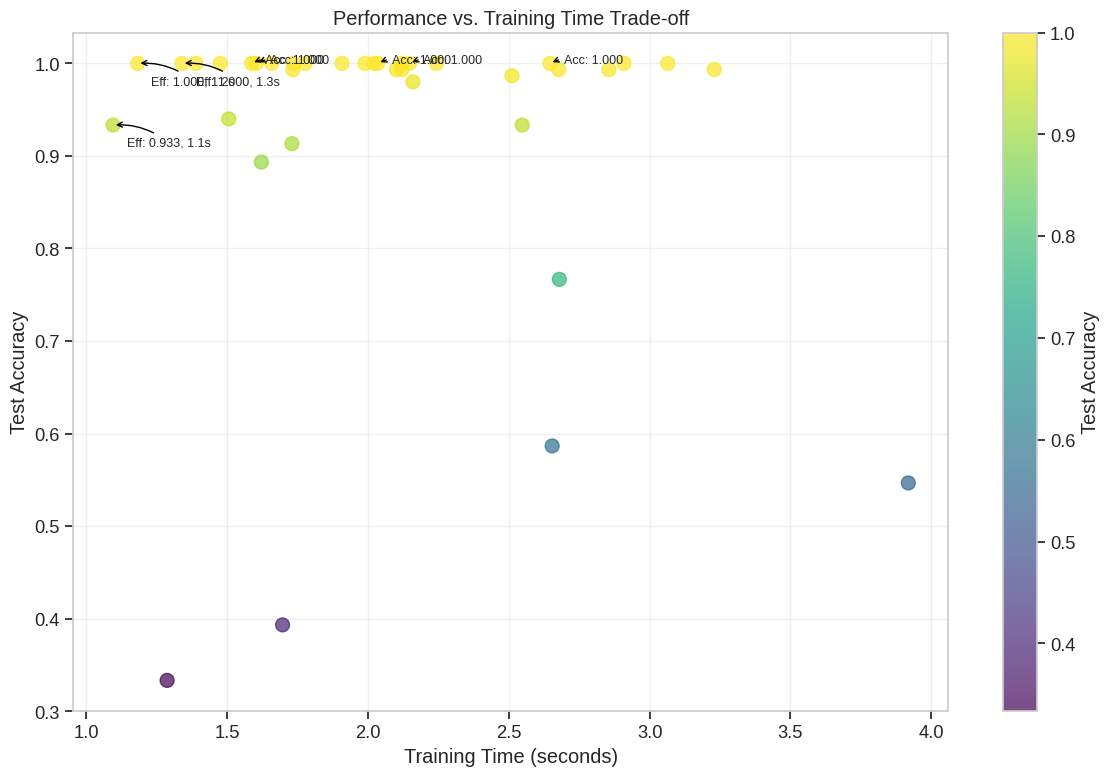

Most efficient configurations (highest accuracy per second):


,test_acc,time,efficiency,d_model,nhead,num_layers,dropout_rate,learning_rate,batch_size,optimizer,pooling_strategy,use_conv1d,gradient_clip
4,0.933333,1.094688,0.852602,64,2,2,0.1,0.001,32,Adam,mean,True,1.0
36,1.000000,1.181943,0.846064,64,4,2,0.1,0.001,32,Adam,mean,False,1.0
24,1.000000,1.339490,0.746553,128,2,2,0.1,0.001,32,Adam,mean,True,1.0
11,1.000000,1.389189,0.719845,64,4,2,0.0,0.001,32,Adam,mean,True,1.0
25,1.000000,1.475817,0.677591,128,4,2,0.1,0.001,32,Adam,mean,True,1.0


In [18]:
# Add a performance vs. time analysis with robust error handling
def analyze_efficiency(results_df, X):
    """
    Analyze the efficiency of different model configurations.
    
    Args:
        results_df: DataFrame with experiment results
        X: DataFrame with feature data for column names
    """
    try:
        plt.figure(figsize=(12, 8))
        
        # Create scatter plot
        scatter = plt.scatter(
            results_df['time'], 
            results_df['test_acc'], 
            c=results_df['test_acc'], 
            cmap='viridis', 
            alpha=0.7, 
            s=100
        )
        
        plt.colorbar(scatter, label='Test Accuracy')
        plt.xlabel('Training Time (seconds)')
        plt.ylabel('Test Accuracy')
        plt.title('Performance vs. Training Time Trade-off')
        plt.grid(True, alpha=0.3)
        
        # Try to annotate best performers
        try:
            if len(results_df) >= 5:
                # Top 5 by accuracy
                for i, row in results_df.nlargest(min(5, len(results_df)), 'test_acc').iterrows():
                    plt.annotate(
                        f"Acc: {row['test_acc']:.3f}",
                        xy=(row['time'], row['test_acc']),
                        xytext=(10, 0),
                        textcoords='offset points',
                        fontsize=9,
                        arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2')
                    )
                
                # Most efficient models (good accuracy, fast training)
                high_acc_models = results_df[results_df['test_acc'] > 0.8]
                if len(high_acc_models) >= 3:
                    for i, row in high_acc_models.nsmallest(min(3, len(high_acc_models)), 'time').iterrows():
                        plt.annotate(
                            f"Eff: {row['test_acc']:.3f}, {row['time']:.1f}s",
                            xy=(row['time'], row['test_acc']),
                            xytext=(10, -15),
                            textcoords='offset points',
                            fontsize=9,
                            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2')
                        )
        except Exception as e:
            print(f"Warning: Could not annotate plot: {e}")
        
        plt.tight_layout()
        plt.savefig('transformer_efficiency_analysis.png')
        plt.show()
        
        # Calculate efficiency metric
        try:
            # Copy to avoid modifying original
            eff_df = results_df.copy()
            eff_df['efficiency'] = eff_df['test_acc'] / eff_df['time']
            
            if len(eff_df) > 0:
                # Get most efficient configurations
                most_efficient = eff_df.nlargest(min(5, len(eff_df)), 'efficiency')
                
                print("Most efficient configurations (highest accuracy per second):")
                cols_to_show = ['test_acc', 'time', 'efficiency']
                param_cols = [col for col in eff_df.columns if col in baseline_params]
                display(most_efficient[cols_to_show + param_cols])
            else:
                print("No results available for efficiency analysis")
        except Exception as e:
            print(f"Warning: Could not calculate efficiency metrics: {e}")
            
    except Exception as e:
        print(f"Error in efficiency analysis: {e}")
        print("Skipping performance vs. time analysis")

# Run the efficiency analysis
print("\n--- Performance vs. Training Time Analysis ---")
if 'all_combined_results' in locals() and len(all_combined_results) > 0:
    analyze_efficiency(all_combined_results, X)
elif len(all_results_df) > 0:
    analyze_efficiency(all_results_df, X)
else:
    print("No results available for efficiency analysis")

## 8. Summary and Next Steps

In this notebook, we've systematically analyzed how different hyperparameters affect the performance of the `TransformerClassifier` model on synthetic cosine data. This controlled experiment helps us understand the relative importance of various parameters.

### Key Takeaways

1. We identified which hyperparameters have the largest impact on model performance
2. We discovered interactions between parameters like pooling strategy and use of Conv1D layers
3. We found the optimal configuration for classifying cosine signals with different frequencies
4. We analyzed the trade-off between model accuracy and training time

### Next Steps

- Compare these findings with the results from the real data grid search (IY006B.csv)
- Investigate whether the most important parameters are consistent across different datasets
- Use these insights to design more focused hyperparameter searches for real-world problems
- Consider running similar experiments with different types of synthetic data to test robustness

Remember that synthetic data provides a controlled environment for understanding parameter impacts, but real-world data may present different challenges that require different optimal settings.